In [53]:
import uproot as up
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import vector
#import zfit
import mplhep as hep
import yaml
import seaborn as sns
import particle
import vector
from CMS_cuts import CMS_cut_func
from uncertainties import ufloat
hep.style.use('ATLAS')
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
import pandas as pd
intum=3
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import tensorflow.keras.backend as K
import uncertainties.unumpy as unp

In [54]:
def corr_coeff(a,b):
    a_resample=[]
    b_resample=[]
    for i in range(len(unp.nominal_values(a))):
        if unp.nominal_values(a)[i]<0:

            a_bootstrap=np.random.poisson(np.abs(unp.nominal_values(a)[i]),1000)
            a_resample.append(-a_bootstrap)
        else:
            a_bootstrap=np.random.poisson(unp.nominal_values(a)[i],1000)
            a_resample.append(a_bootstrap)
        if unp.nominal_values(b)[i]<0:

            b_bootstrap=np.random.poisson(np.abs(unp.nominal_values(b)[i]),1000)
            b_resample.append(-b_bootstrap)
        else:
            b_bootstrap=np.random.poisson(unp.nominal_values(b)[i],1000)
            b_resample.append(b_bootstrap)
        

    a_resample=np.concatenate(a_resample)
    b_resample=np.concatenate(b_resample)
    cov = np.cov(a_resample, b_resample, ddof=0)[0, 1]
    sigma_a = np.std(a_resample)
    sigma_b = np.std(b_resample)
    rho = cov / (sigma_a * sigma_b)
    return rho
def error_propagation(a,operation,b):
    rho=corr_coeff(a,b)
    a_nom=unp.nominal_values(a)
    b_nom=unp.nominal_values(b)
    a_err=unp.std_devs(a)
    b_err=unp.std_devs(b)


    if operation=="/":
        
        result=a_nom/b_nom

        result_err=np.sqrt(  (a_err/b_nom)**2 +((a_nom*b_err/b_nom**2)**2  ))

        

    if operation=='-':

        result=a_nom-b_nom

        result_err=np.sqrt(a_err**2+b_err**2 - 2*rho*a_err*b_err)


    if operation=='+':
        result=a_nom+b_nom

        result_err=np.sqrt(a_err**2+ b_err**2 + 2*rho*a_err*b_err)
    
    return unp.uarray(result,result_err)


In [55]:
def to_categorical(labels, num_classes=None):

    # get num_classes from max label if None
    if num_classes is None:
        num_classes = int(np.max(labels)) + 1

    y = np.asarray(labels, dtype=int)
    n = y.shape[0]
    categorical = np.zeros((n, num_classes))

    # index into array and set appropriate values to 1
    categorical[np.arange(n), y] = 1

    return categorical

In [56]:
sim_det, sim_part, data_det, data_part = pd.read_csv('/Users/claudiumihai/MPhys/Analysis/Workflow/Pre_Omnifold/Data_outputs/DataSM_Detector_level_new_jet_veto.csv'),\
    pd.read_csv('/Users/claudiumihai/MPhys/Analysis/Workflow/Pre_Omnifold/Data_outputs/DataSM_Particle_level_new_jet_veto.csv'),\
        pd.read_csv('/Users/claudiumihai/MPhys/Analysis/Workflow/Pre_Omnifold/Data_outputs/DataEFT_cp_odd_cwtil1_Detector_level.csv'),\
            pd.read_csv('/Users/claudiumihai/MPhys/Analysis/Workflow/Pre_Omnifold/Data_outputs/DataEFT_cp_odd_cwtil1_Particle_level.csv')

In [57]:
lumi=138
tree=up.open('/Users/claudiumihai/MPhys/Analysis/Workflow/ROOT_FILES/SM/CMS_500k.root:Delphes')
w_full_sm=tree.arrays(['Event.Weight'],library='ak')
sim_part['Event.Weight']=w_full_sm[sim_part['Unnamed: 0']]['Event.Weight']
sim_const=lumi*0.9962*1000/np.sum(w_full_sm['Event.Weight'])

In [58]:
tree=up.open('/Users/claudiumihai/MPhys/Analysis/Workflow/ROOT_FILES/EFT/CP_odd/EFT_cp_odd_cwtil1.root:Delphes')
w_full_np1=tree.arrays(['Event.Weight'],library='ak')
data_part['Event.Weight']=w_full_np1[data_part['Unnamed: 0']]['Event.Weight']

data_const=lumi*1.153*1000/np.sum(w_full_np1['Event.Weight'])
print(np.sum(w_full_np1['Event.Weight'])/len(w_full_np1))


1.153137


In [59]:
sim_det['Lepton.PT']=sim_det.apply(lambda row : row ['Electron.PT'] if row['Electron_size']==1 else row['Muon.PT'],axis=1)
sim_det['Lepton.Eta']=sim_det.apply(lambda row : row ['Electron.Eta'] if row['Electron_size']==1 else row['Muon.Eta'],axis=1)
sim_det['Lepton.Phi']=sim_det.apply(lambda row : row ['Electron.Phi'] if row['Electron_size']==1 else row['Muon.Phi'],axis=1)

In [60]:
sim_part['Lepton.PT']=sim_part.apply(lambda row : row ['Electron.PT'] if row['Electron_size']==1 else row['Muon.PT'],axis=1)
sim_part['Lepton.Eta']=sim_part.apply(lambda row : row ['Electron.Eta'] if row['Electron_size']==1 else row['Muon.Eta'],axis=1)
sim_part['Lepton.Phi']=sim_part.apply(lambda row : row ['Electron.Phi'] if row['Electron_size']==1 else row['Muon.Phi'],axis=1)

In [61]:
data_det['Lepton.PT']=data_det.apply(lambda row : row ['Electron.PT'] if row['Electron_size']==1 else row['Muon.PT'],axis=1)
data_det['Lepton.Eta']=data_det.apply(lambda row : row ['Electron.Eta'] if row['Electron_size']==1 else row['Muon.Eta'],axis=1)
data_det['Lepton.Phi']=data_det.apply(lambda row : row ['Electron.Phi'] if row['Electron_size']==1 else row['Muon.Phi'],axis=1)

In [62]:
data_part['Lepton.PT']=data_part.apply(lambda row : row ['Electron.PT'] if row['Electron_size']==1 else row['Muon.PT'],axis=1)
data_part['Lepton.Eta']=data_part.apply(lambda row : row ['Electron.Eta'] if row['Electron_size']==1 else row['Muon.Eta'],axis=1)
data_part['Lepton.Phi']=data_part.apply(lambda row : row ['Electron.Phi'] if row['Electron_size']==1 else row['Muon.Phi'],axis=1)

In [63]:
data_det=data_det.loc[(data_det['Lepton.PT']<400) &(data_det['Photon.PT']<400)  & (data_det['MissingET.MET']<400)]
data_part=data_part.loc[(data_part['Lepton.PT']<400) &(data_part['Photon.PT']<400)  & (data_part['MissingET.MET']<400)]
sim_det=sim_det.loc[(sim_det['Lepton.PT']<400) &(sim_det['Photon.PT']<400)  & (sim_det['MissingET.MET']<400)]
sim_part=sim_part.loc[(sim_part['Lepton.PT']<400) &(sim_part['Photon.PT']<400)  & (sim_part['MissingET.MET']<400)]

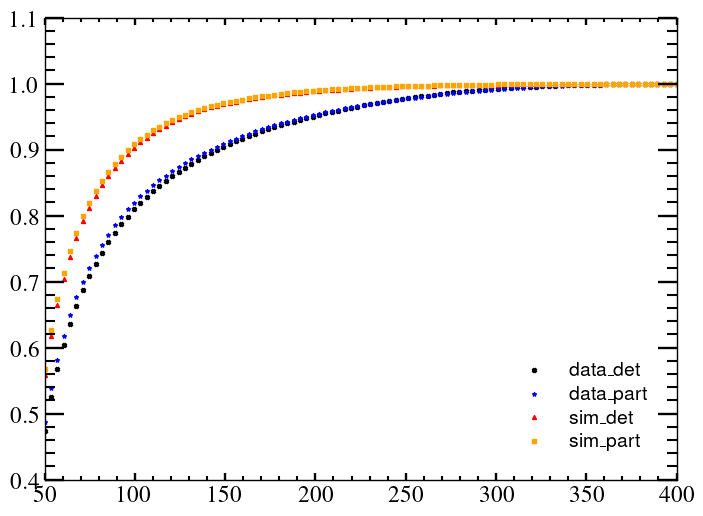

In [64]:
cut=np.linspace(50,400,100)
sets=[data_det,data_part,sim_det,sim_part]
labels=['data_det','data_part','sim_det','sim_part']
colors=['black','blue','red','orange']
markers=['x','*','^','s']
plt.figure()
for (data,color,l,m) in zip(sets,colors,labels,markers):
    temp=[]
    for c in cut:
        if l in temp:
            l=''
        else:
            label=l
            temp.append(l)
        plt.scatter(c,len(data.loc[data['Lepton.PT']<c])/len(data),color=color,s=8,label=l,marker=m)
#plt.yscale('log')
plt.legend()
plt.show()

In [65]:
len(sim_part)

123469

In [66]:
unfold_vars=['Lepton.PT','Lepton.Phi','Lepton.Eta','Photon.PT','Photon.Eta','Photon.Phi','MissingET.MET','MissingET.Phi']

In [67]:
X_det=np.asarray([np.concatenate((data_det[var],sim_det[var])) for var in unfold_vars]).T
Y_det=to_categorical(np.concatenate(( np.ones(len(data_det['Lepton.Eta'])),
                                             np.zeros(len(sim_det['Lepton.Eta']))   )))





X_gen=np.asarray([np.concatenate((sim_part[var],sim_part[var])) for var in unfold_vars]).T
Y_gen=to_categorical(np.concatenate(( np.ones(len(sim_part['Lepton.Eta'])),
                                             np.zeros(len(sim_part['Lepton.Eta']))   )))


ndata, nsim = np.count_nonzero(Y_det[:,1]), np.count_nonzero(Y_det[:,0])
wdata = np.ones(ndata)
winit = ndata/nsim*np.ones(nsim)

In [68]:
sim_det['event']=sim_det['Unnamed: 0']
sim_part['event']=sim_part['Unnamed: 0']
data_det['event']=None

In [69]:
input_det=pd.concat([pd.DataFrame(data_det[unfold_vars+['event']]),pd.DataFrame(sim_det[unfold_vars+['event']])])
input_det['target']=np.concatenate((np.ones(len(data_det)),np.zeros(len(sim_det))))
input_det['w']=np.concatenate((np.ones(len(data_det)),winit*  sim_det['Event.Weight'])  )

input_gen=pd.concat([pd.DataFrame(sim_part[unfold_vars+['event']]),pd.DataFrame(sim_part[unfold_vars+['event']])])
input_gen['target']=np.concatenate((np.ones(len(sim_part)),np.zeros(len(sim_part))))
input_gen['w']=np.concatenate((np.ones(len(sim_part)),np.ones(len(sim_part))))

In [70]:
D=np.array(sim_det['Unnamed: 0'])
P=np.array(sim_part['Unnamed: 0'])                              

In [71]:
full_set_events=np.unique(np.concatenate((D,P)))

In [72]:
common_events=np.intersect1d(D,P)
det_eff_events=np.setdiff1d(P,D)
neutrino_eff_events=np.setdiff1d(D,P)
particle_events=P

In [73]:
def normalize_columns(df, columns):
    df_normalized = df[columns].copy()  # Work only on the specified columns
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val - min_val == 0:  # Avoid division by zero
            df_normalized[col] = 0
        else:
            df_normalized[col] = (df[col] - min_val) / (max_val - min_val)
    return df_normalized

In [74]:
def normalize_columns_to_minus1_1(df, columns):
    df_normalized = df[columns].copy()  # Work only on the specified columns
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val - min_val == 0:  # Avoid division by zero
            df_normalized[col] = 0
        else:
            # Normalize to [-1, 1]
            df_normalized[col] = 2 * (df[col] - min_val) / (max_val - min_val) - 1
    return df_normalized

In [75]:
coin_flip=np.random.uniform(0,1,max(len(data_det),len(sim_det),len(data_part),len(sim_part)))    


In [76]:
coin_flip

array([5.43775585e-01, 1.71784816e-01, 4.24876676e-03, ...,
       2.03695482e-04, 4.90707344e-01, 9.96795423e-01])

In [77]:
data_det['coin_flip']=coin_flip[:len(data_det)]
sim_det['coin_flip']=coin_flip[:len(sim_det)]
sim_part['coin_flip']=coin_flip[:len(sim_part)]
data_part['coin_flip']=coin_flip[:len(data_part)]

In [78]:
def phi_detector(data_df):
    W_boson=particle.Particle.from_pdgid(24)
    M_w=W_boson.mass/1000

    data_df['large_boost']=0.0
    data_df.loc[data_df['Electron_size']==1,'large_boost']=M_w**2/(data_df['Electron.PT']*data_df['MissingET.MET'])
    data_df.loc[data_df['Muon_size']==1,'large_boost']=M_w**2/(data_df['Muon.PT']*data_df['MissingET.MET'])

    data_df['delta']=0.0
    data_df.loc[data_df['Electron_size']==1,'delta']=(M_w**2-data_df['Mt_lv']**2)/(2*data_df['Electron.PT']*data_df['MissingET.MET'])
    data_df.loc[data_df['Muon_size']==1,'delta']=(M_w**2-data_df['Mt_lv']**2)/(2*data_df['Muon.PT']*data_df['MissingET.MET'])


    data_df['lepton_mass']=0.0
    data_df.loc[data_df['Muon_size']==1,'lepton_mass']=particle.Particle.from_pdgid(13).mass/1000
    data_df.loc[data_df['Electron_size']==1,'lepton_mass']=particle.Particle.from_pdgid(11).mass/1000
    data_df['Mt_lv']=0.0


    data_df.loc[data_df['Electron_size']==1,'Mt_lv']=np.sqrt(  
        ( data_df['MissingET.MET']+ np.sqrt((data_df['Electron.PT'])**2+data_df['lepton_mass']**2))**2 
        - (   data_df['Electron.PT']*np.cos(data_df['Electron.Phi']) +data_df['MissingET.MET']*np.cos(data_df['MissingET.Phi'])  )**2
            - (   data_df['Electron.PT']*np.sin(data_df['Electron.Phi']) +data_df['MissingET.MET']*np.sin(data_df['MissingET.Phi'])  )**2   )

    data_df.loc[data_df['Muon_size']==1,'Mt_lv']=np.sqrt(  
        ( data_df['MissingET.MET']+ np.sqrt((data_df['Muon.PT'])**2+data_df['lepton_mass']**2))**2 
        - (   data_df['Muon.PT']*np.cos(data_df['Muon.Phi']) +data_df['MissingET.MET']*np.cos(data_df['MissingET.Phi'])  )**2
            - (   data_df['Muon.PT']*np.sin(data_df['Muon.Phi']) +data_df['MissingET.MET']*np.sin(data_df['MissingET.Phi'])  )**2   )


    data_df['large_boost']=0.0
    data_df.loc[data_df['Electron_size']==1,'large_boost']=M_w**2/(data_df['Electron.PT']*data_df['MissingET.MET'])
    data_df.loc[data_df['Muon_size']==1,'large_boost']=M_w**2/(data_df['Muon.PT']*data_df['MissingET.MET'])

    data_df['delta']=0.0
    data_df.loc[data_df['Electron_size']==1,'delta']=(M_w**2-data_df['Mt_lv']**2)/(2*data_df['Electron.PT']*data_df['MissingET.MET'])
    data_df.loc[data_df['Muon_size']==1,'delta']=(M_w**2-data_df['Mt_lv']**2)/(2*data_df['Muon.PT']*data_df['MissingET.MET'])


    data_df['sign']=np.sign(data_df['delta'])
    data_df.loc[(data_df['sign']==-1.0) & (data_df['Electron_size']==1),'Eta_v']=data_df['Electron.Eta']
    data_df.loc[(data_df['sign']==-1.0) & (data_df['Muon_size']==1),'Eta_v']=data_df['Muon.Eta']

    def eta_based_on_coin_flip(row):
        eta_plus = row['Electron.Eta'] + np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
        eta_minus = row['Electron.Eta'] - np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
        # Select based on coin_flip value
        return eta_plus if row['coin_flip']  <0.5 else eta_minus #np.random.choice([eta_plus,eta_minus])#e

    data_df.loc[(data_df['Electron_size'] == 1) & (data_df['delta'] >= 0), 'Eta_v'] = data_df[
        (data_df['Electron_size'] == 1) & (data_df['delta'] >= 0)
    ].apply(eta_based_on_coin_flip, axis=1)

    def eta_based_on_coin_flip(row):
        eta_plus = row['Muon.Eta'] + np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
        eta_minus = row['Muon.Eta'] - np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
        # Select based on coin_flip value
        return eta_plus if row['coin_flip'] <0.5 else eta_minus #np.random.choice([eta_plus,eta_minus]) #e

    # Apply the updated function
    data_df.loc[(data_df['Muon_size'] == 1) & (data_df['delta'] >= 0), 'Eta_v'] = data_df[
        (data_df['Muon_size'] == 1) & (data_df['delta'] >= 0)
    ].apply(eta_based_on_coin_flip, axis=1)





    def phi_transf(phi):
        return np.piecewise(
        phi,
        [
            phi < -np.pi / 2,  
            np.abs(phi) < np.pi / 2,  
            phi > np.pi / 2  
        ],
        [
            lambda phi: -(np.pi + phi),  
            lambda phi: phi,  
            lambda phi: np.pi - phi  
        ]
    )

    def phi_recon(charge,particle):

        p_l=vector.zip({'pt':data_df[particle+'.PT'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)] ,'eta':data_df[particle+'.Eta'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],
                        'phi':data_df[particle+'.Phi'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],'mass':data_df['lepton_mass'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)]  })
        p_y=vector.zip({'pt':data_df['Photon.PT'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)] ,'eta':data_df['Photon.Eta'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],
                        'phi':data_df['Photon.Phi'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],'mass':0 })

        p_vl=vector.zip({'pt':data_df['MissingET.MET'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)] ,'eta':data_df['Eta_v'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],
                    'phi':data_df['MissingET.Phi'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],'mass':0 })


        p_w=p_l+p_vl
        p_com=p_w+p_y
        p_w_boosted=p_w.boost(-p_com.to_beta3())
        p_l_boosted=p_l.boost(-p_com.to_beta3())
        p_vl_boosted=p_vl.boost(-p_com.to_beta3())

        n1=p_w_boosted.to_Vector3D().cross(-p_com.to_Vector3D())    
        n1=n1/n1.mag

        n_ref=n1.cross(p_w_boosted.to_Vector3D())
        n_ref=n_ref/n_ref.mag
        if charge==1.0:
            n2=-p_l_boosted.to_Vector3D().cross(p_w_boosted.to_Vector3D())
        elif charge==-1.0:
            n2=-p_vl_boosted.to_Vector3D().cross(p_w_boosted.to_Vector3D())
        else: return 'error'

        n2=n2/n2.mag   

        x=n2.dot(n1)
        y=n2.dot(n_ref)

        phi=-np.arctan2(y,x)
        phi=np.array(phi)

        return phi



    data_df['Phi']=0.0

    data_df.loc[(data_df['Electron_size']==1) & (data_df['Electron.Charge']==1.0),'phi']=phi_recon(1.0,'Electron')
    data_df.loc[(data_df['Electron_size']==1) & (data_df['Electron.Charge']==-1.0),'phi']=phi_recon(-1.0,'Electron')

    data_df.loc[(data_df['Muon_size']==1) & (data_df['Muon.Charge']==1.0),'phi']=phi_recon(1.0,'Muon')
    data_df.loc[(data_df['Muon_size']==1) & (data_df['Muon.Charge']==-1.0),'phi']=phi_recon(-1.0,'Muon')

    return data_df


In [79]:
def phi_particle(data_df):


    def phi_transf(phi):
        return np.piecewise(
        phi,
        [
            phi < -np.pi / 2,  
            np.abs(phi) < np.pi / 2,  
            phi > np.pi / 2  
        ],
        [
            lambda phi: -(np.pi + phi),  
            lambda phi: phi,  
            lambda phi: np.pi - phi  
        ]
    )

    def phi_recon(charge,particle):

        p_l=vector.zip({'pt':data_df[particle+'.PT'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)] ,'eta':data_df[particle+'.Eta'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],
                        'phi':data_df[particle+'.Phi'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],'mass':data_df['lepton_mass'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)]  })
        p_y=vector.zip({'pt':data_df['Photon.PT'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)] ,'eta':data_df['Photon.Eta'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],
                        'phi':data_df['Photon.Phi'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],'mass':0 })

        p_vl=vector.zip({'pt':data_df['MissingET.MET'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)] ,'eta':data_df['MissingET.Eta'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],
                    'phi':data_df['MissingET.Phi'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],'mass':0 })


        p_w=p_l+p_vl
        p_com=p_w+p_y
        p_w_boosted=p_w.boost(-p_com.to_beta3())
        p_l_boosted=p_l.boost(-p_com.to_beta3())
        p_vl_boosted=p_vl.boost(-p_com.to_beta3())

        n1=p_w_boosted.to_Vector3D().cross(-p_com.to_Vector3D())    
        n1=n1/n1.mag

        n_ref=n1.cross(p_w_boosted.to_Vector3D())
        n_ref=n_ref/n_ref.mag
        if charge==1.0:
            n2=-p_l_boosted.to_Vector3D().cross(p_w_boosted.to_Vector3D())
        elif charge==-1.0:
            n2=-p_vl_boosted.to_Vector3D().cross(p_w_boosted.to_Vector3D())
        else: return 'error'

        n2=n2/n2.mag   

        x=n2.dot(n1)
        y=n2.dot(n_ref)

        phi=-np.arctan2(y,x)
        phi=np.array(phi)

        return phi



    data_df['Phi']=0.0

    data_df.loc[(data_df['Electron_size']==1) & (data_df['Electron.Charge']==1.0),'phi_true']=phi_recon(1.0,'Electron')
    data_df.loc[(data_df['Electron_size']==1) & (data_df['Electron.Charge']==-1.0),'phi_true']=phi_recon(-1.0,'Electron')

    data_df.loc[(data_df['Muon_size']==1) & (data_df['Muon.Charge']==1.0),'phi_true']=phi_recon(1.0,'Muon')
    data_df.loc[(data_df['Muon_size']==1) & (data_df['Muon.Charge']==-1.0),'phi_true']=phi_recon(-1.0,'Muon')

    return data_df


In [80]:
sim_part=phi_detector(sim_part)
sim_det=phi_detector(sim_det)

data_part=phi_detector(data_part)
data_det=phi_detector(data_det)


sim_part=phi_particle(sim_part)
data_part=phi_particle(data_part)

In [81]:
def dPhi_l_y(data_df):
    for i in data_df.index:
        if data_df['Lepton.Eta'][i]>data_df['Photon.Eta'][i]:
            temp=data_df['Lepton.Phi'][i]-data_df['Photon.Phi'][i]
            if temp>np.pi:
                data_df.at[i,'dPhi']=temp-np.pi
            elif temp<-np.pi:
                data_df.at[i,'dPhi']=temp+np.pi
            else:
                data_df.at[i,'dPhi']=temp
        else:
            temp=data_df['Photon.Phi'][i]-data_df['Lepton.Phi'][i]
            if temp>np.pi:
                data_df.at[i,'dPhi']=temp-np.pi
            elif temp<-np.pi:
                 data_df.at[i,'dPhi']=temp+np.pi
            else:
                 data_df.at[i,'dPhi']=temp
            
    return data_df

In [82]:
sim_det=dPhi_l_y(sim_det)
sim_part=dPhi_l_y(sim_part)
data_det=dPhi_l_y(data_det)
data_part=dPhi_l_y(data_part)

<Axes: xlabel='coin_flip', ylabel='Count'>

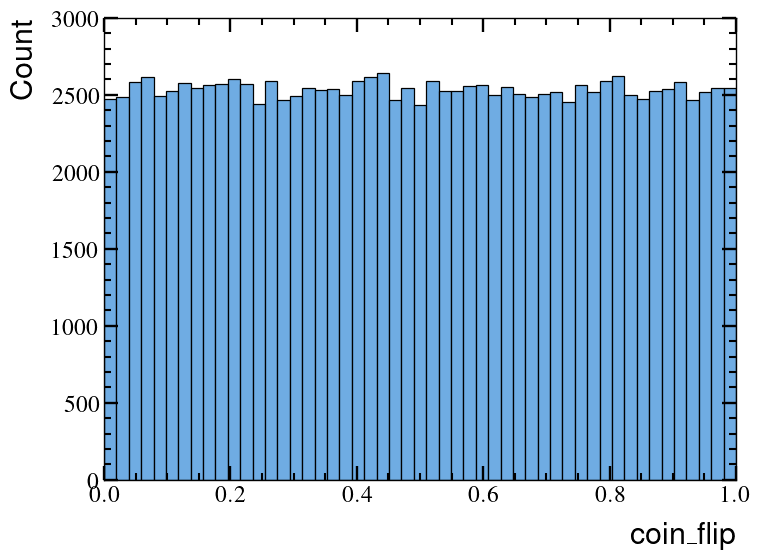

In [91]:
sns.histplot(data_part['coin_flip'])

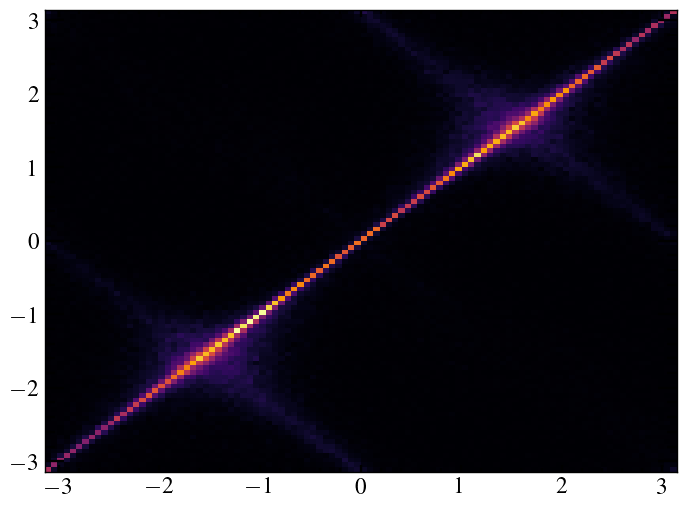

In [83]:
plt.hist2d(data_part['phi_true'],data_part['phi'],bins=[100,100],cmap='inferno')
plt.show()

In [84]:
#unfold_vars=['Lepton.Phi','Photon.Phi','Lepton.Eta','Photon.Eta','Lepton.PT','Eta_v']
unfold_vars=['Lepton.Phi','Lepton.Eta','Photon.Phi','Photon.Eta','MissingET.Phi','Lepton.PT','MissingET.MET','Photon.PT','Eta_v']
#unfold_vars=['Lepton.Phi','Lepton.Eta','Photon.Phi','Photon.Eta','MissingET.Phi','Lepton.PT','MissingET.MET','Photon.PT']
#unfold_vars=['Lepton.PT','Photon.PT','MissingET.MET']
weights_push=np.ones(len(sim_part['Lepton.PT']))
weights_pull=np.ones(len(sim_part['Lepton.PT']))


data_det[unfold_vars]  = normalize_columns(data_det,unfold_vars)
sim_det[unfold_vars]  = normalize_columns(sim_det,unfold_vars)
data_part[unfold_vars]  = normalize_columns(data_part,unfold_vars)
sim_part[unfold_vars]  = normalize_columns(sim_part,unfold_vars)


input_det=pd.concat([pd.DataFrame(data_det[unfold_vars+['event']]),pd.DataFrame(sim_det[unfold_vars+['event']])])
input_det['target']=np.concatenate((np.ones(len(data_det)),np.zeros(len(sim_det))))
#input_det['w']=np.concatenate((np.ones(len(data_det)),winit*  sim_det['Event.Weight'])  )

input_gen=pd.concat([pd.DataFrame(sim_part[unfold_vars+['event']]),pd.DataFrame(sim_part[unfold_vars+['event']])])
input_gen['target']=np.concatenate((np.ones(len(sim_part)),np.zeros(len(sim_part))))



#input_gen['w']=np.concatenate((np.ones(len(sim_part)),np.ones(len(sim_part))))

#input_det[unfold_vars] = (input_det[unfold_vars] - np.mean(input_det[unfold_vars], axis=0))/np.std(input_det[unfold_vars], axis=0)
#input_gen[unfold_vars] = (input_gen[unfold_vars] - np.mean(input_gen[unfold_vars], axis=0))/np.std(input_gen[unfold_vars], axis=0)


n=len(unfold_vars)


inputs_step1 = Input((n, ))
hidden_layer_1_step1 = Dense(100, activation='relu')(inputs_step1)
hidden_layer_2_step1 = Dense(100, activation='relu')(hidden_layer_1_step1)
hidden_layer_3_step1 = Dense(100, activation='relu')(hidden_layer_2_step1)
#hidden_layer_4_step1 = Dense(30, activation='relu')(hidden_layer_3_step1)

outputs_step1 = Dense(1, activation='sigmoid')(hidden_layer_1_step1)
model_step1 = Model(inputs=inputs_step1, outputs=outputs_step1)


weights_push=np.ones(len(full_set_events))
weights_pull=np.ones(len(full_set_events))

push_mapping=dict(zip(full_set_events,weights_push))
pull_mapping=dict(zip(full_set_events,weights_pull))




inputs_step2 = Input((n, ))
hidden_layer_1_step2 = Dense(100, activation='relu')(inputs_step2)
hidden_layer_2_step2 = Dense(100, activation='relu')(hidden_layer_1_step2)
hidden_layer_3_step2 = Dense(100, activation='relu')(hidden_layer_2_step2)
#hidden_layer_4_step2 = Dense(30, activation='relu')(hidden_layer_3_step2)

outputs_step2 = Dense(1, activation='sigmoid')(hidden_layer_3_step2)
model_step2 = Model(inputs=inputs_step2, outputs=outputs_step2)

push_series=pd.Series(push_mapping)
pull_series=pd.Series(pull_mapping)
push_series.loc[D]=np.array(sim_det['Event.Weight'])*winit
data_weights=np.array(data_det['Event.Weight'])

In [85]:
for i in range(5):

    w1=np.concatenate((data_weights,push_series.loc[D]))

    model_step1 = Model(inputs=inputs_step1, outputs=outputs_step1)
    X_train,X_test,y_train,y_test,w_train,w_test=train_test_split(input_det[unfold_vars],
                                                                  input_det['target'],
                                                                  w1)
    #model_cls=xgb.XGBClassifier(**best_params)

    #model_cls.fit(X_train,y_train,sample_weight=w_train)

    #f= model_cls.predict_proba(sim_det.loc[sim_det['event'].isin(common_events)][unfold_vars])[:,1]

    model_step1.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

    model_step1.fit(X_train,y_train,sample_weight=w_train,epochs=50,batch_size=1500,validation_data=(X_test,y_test,w_test),verbose=False)

    f=model_step1.predict(sim_det.loc[sim_det['event'].isin(common_events)][unfold_vars],batch_size=700)
    
    temp=f/(1.-f)
    temp=np.squeeze(np.nan_to_num(temp)) 

    pull_series.loc[common_events]=temp*push_series.loc[common_events]


    ## estimation 1

    estimation_1_X=pd.concat([sim_part.loc[sim_part['event'].isin(common_events)][unfold_vars],sim_part.loc[sim_part['event'].isin(common_events)][unfold_vars]])

    estimation_1_Y=np.concatenate((np.ones(len(sim_part.loc[sim_part['event'].isin(common_events)][unfold_vars])), np.zeros(len(sim_part.loc[sim_part['event'].isin(common_events)][unfold_vars]))))
    
    estimation_1_w=np.concatenate((pull_series.loc[common_events],np.ones(len(sim_part.loc[sim_part['event'].isin(common_events)][unfold_vars]))))

    X_t, X_v, y_t, y_v, w_t, w_v = train_test_split(estimation_1_X,estimation_1_Y,estimation_1_w)

    model_estimation_1=Model(inputs=inputs_step1, outputs=outputs_step1)
    model_estimation_1.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

    model_estimation_1.fit(X_t,y_t,sample_weight=w_t,epochs=50,batch_size=700,validation_data=(X_v,y_v,w_v),verbose=False)

    f=model_estimation_1.predict(sim_part.loc[sim_part['event'].isin(det_eff_events)][unfold_vars],batch_size=400)

    temp=f/(1.-f)

    temp=np.squeeze(np.nan_to_num(temp)) 

    pull_series.loc[det_eff_events]=temp

    ##



    
    #pull_series.loc[det_eff_events]=1
    
    
    


    #weights_pull=np.array(sim_part.loc[sim_part['event'].isin(common_events),'w'])*temp
    

    w2=np.concatenate((pull_series[P],push_series[P]))

    model_step2 = Model(inputs=inputs_step2, outputs=outputs_step2)

    X_train,X_test,y_train,y_test,w_train,w_test=train_test_split(input_gen[unfold_vars],
                                                                  input_gen['target'],
                                                                  w2)
    
    #model_cls2=xgb.XGBClassifier(**best_params)

    #model_cls2.fit(X_train,y_train,sample_weight=w_train)
    #f=model_cls2.predict_proba(sim_part[unfold_vars])[:,1]

    model_step2.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

    model_step2.fit(X_train,y_train,sample_weight=w_train,epochs=50,batch_size=2000,validation_data=(X_test,y_test,w_test),verbose=False)


    
    f=model_step2.predict(sim_part[unfold_vars],batch_size=1000)
    
    temp=f/(1.-f)

    temp=np.squeeze(np.nan_to_num(temp)) 
    
    
    push_series.loc[P]=temp*push_series[P]


    ## estimation 2

    estimation_2_X=pd.concat([sim_det.loc[sim_det['event'].isin(common_events)][unfold_vars],sim_det.loc[sim_det['event'].isin(common_events)][unfold_vars]])

    estimation_2_Y=np.concatenate((np.ones(len(sim_det.loc[sim_det['event'].isin(common_events)][unfold_vars])), np.zeros(len(sim_det.loc[sim_det['event'].isin(common_events)][unfold_vars]))))
    
    estimation_2_w=np.concatenate((push_series.loc[common_events],np.ones(len(sim_det.loc[sim_det['event'].isin(common_events)][unfold_vars]))))

    X_t, X_v, y_t, y_v, w_t, w_v = train_test_split(estimation_2_X,estimation_2_Y,estimation_2_w)

    model_estimation_2=Model(inputs=inputs_step2, outputs=outputs_step2)
    model_estimation_2.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

    model_estimation_2.fit(X_t,y_t,sample_weight=w_t,epochs=50,batch_size=700,validation_data=(X_v,y_v,w_v),verbose=False)

    f=model_estimation_2.predict(sim_det.loc[sim_det['event'].isin(neutrino_eff_events)][unfold_vars],batch_size=50)

    temp=f/(1.-f)

    temp=np.squeeze(np.nan_to_num(temp)) 

    push_series.loc[neutrino_eff_events]=temp

    ##



    

    #push_series.loc[neutrino_eff_events]=1

w_push=np.array(push_series.loc[P])
import pickle
with open('/Users/claudiumihai/MPhys/Analysis/Workflow/Pre_Omnifold/Weights_push_new.pkl','wb') as file:
    pickle.dump(w_push,file)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step


In [46]:
w_push=np.array(push_series.loc[P])

In [86]:
push_series.loc[P]

1         1.009116
3         0.859638
4         1.055528
6         1.978197
10        0.949169
            ...   
499991    1.045368
499993    1.419299
499994    0.907927
499996    1.057420
499999    0.959692
Length: 123469, dtype: float64

In [314]:
np.max(push_series.loc[P])

513.8075299161472

In [36]:
import pickle
with open('/Users/claudiumihai/MPhys/Analysis/Workflow/Pre_Omnifold/Weights_push_new.pkl','wb') as file:
    pickle.dump(w_push,file)

In [ ]:
data_sets={'SM':{'particle':sim_part,'detector':sim_det,'weights_detector':sim_det['Event.Weight'],'weights_particle':sim_part['Event.Weight'],'constant':sim_const,'weights_full':w_full_sm},
           'EFT_NP1':{'particle':data_part,'detector':data_det,'weights_detector':data_det['Event.Weight'],'weights_particle':data_part['Event.Weight'],'constant':data_const,'weights_full':w_full_np1},}


0        0.591129
1        0.471928
2        0.268311
3        0.509455
4        0.441068
           ...   
83857    0.694717
83858    0.404090
83859    0.616004
83860    0.318835
83861    0.866352
Name: Eta_v, Length: 83436, dtype: float64

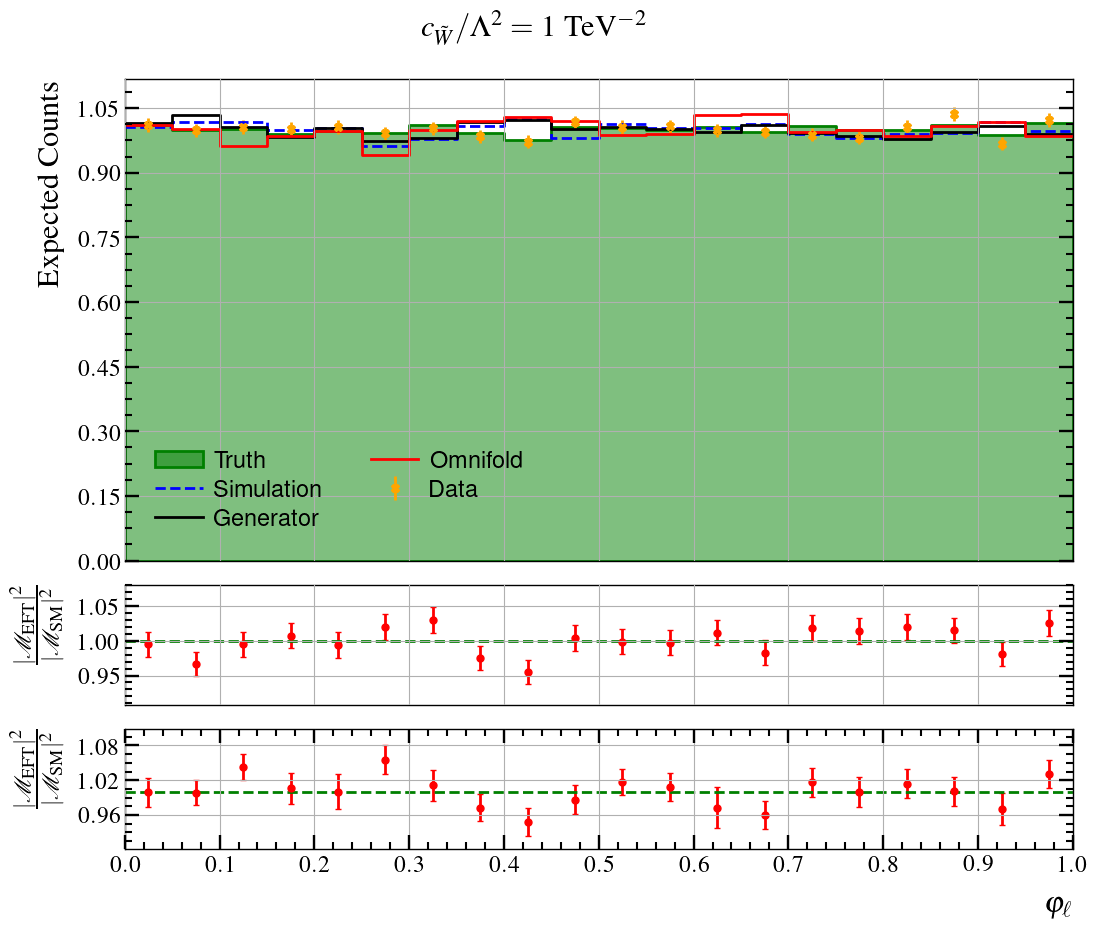

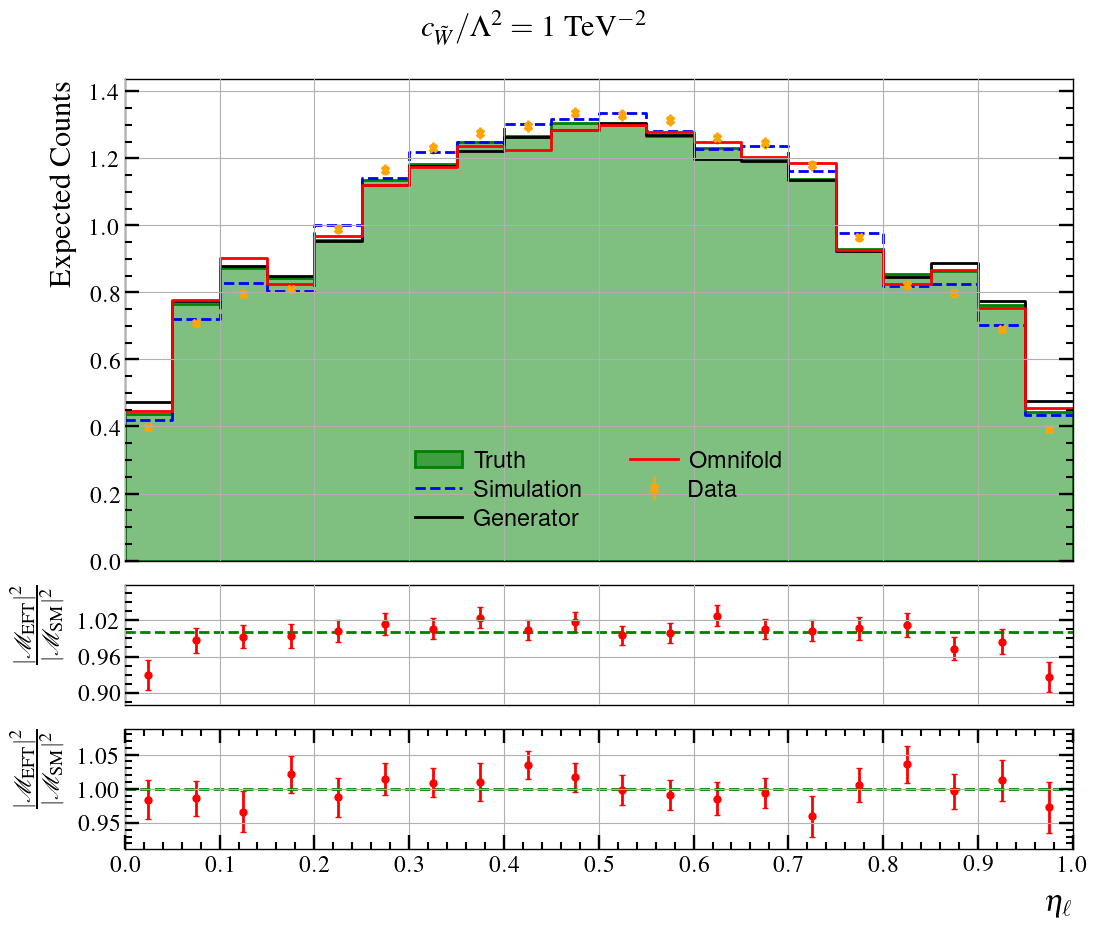

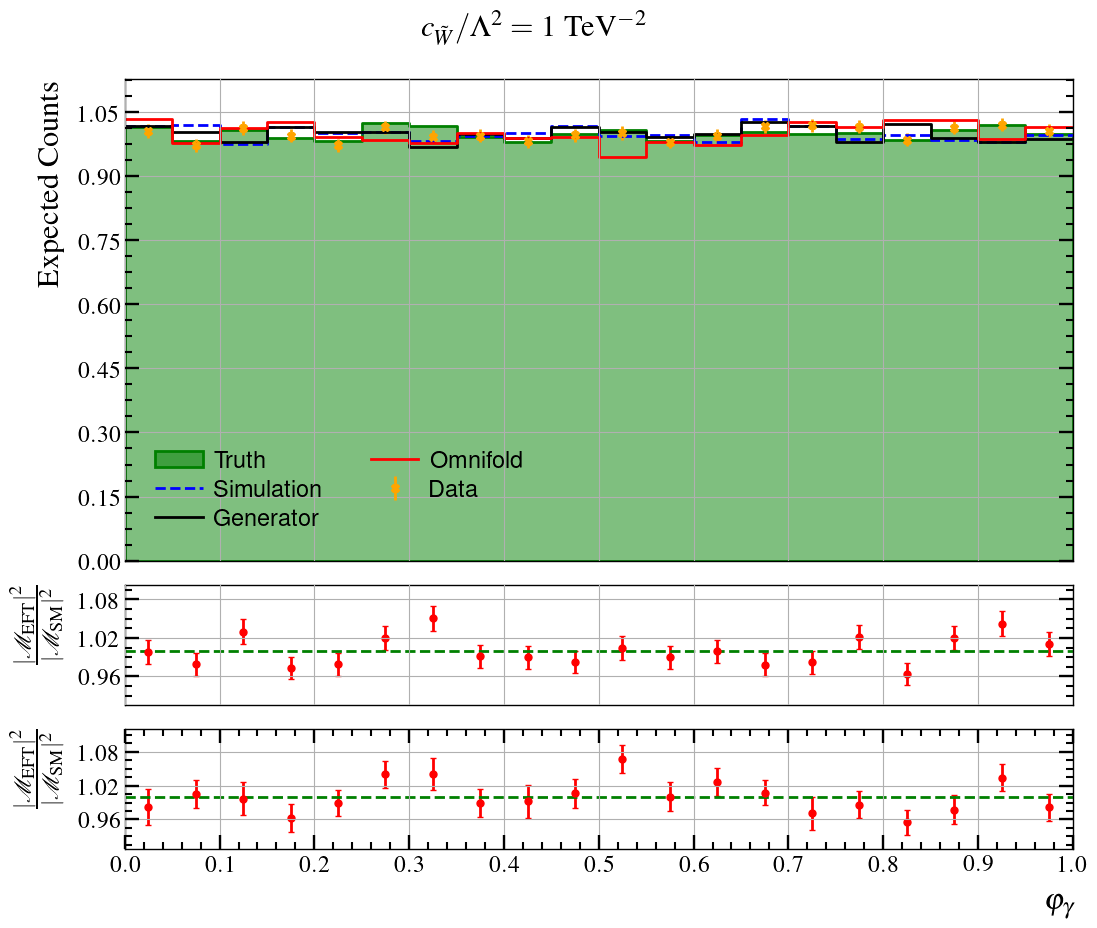

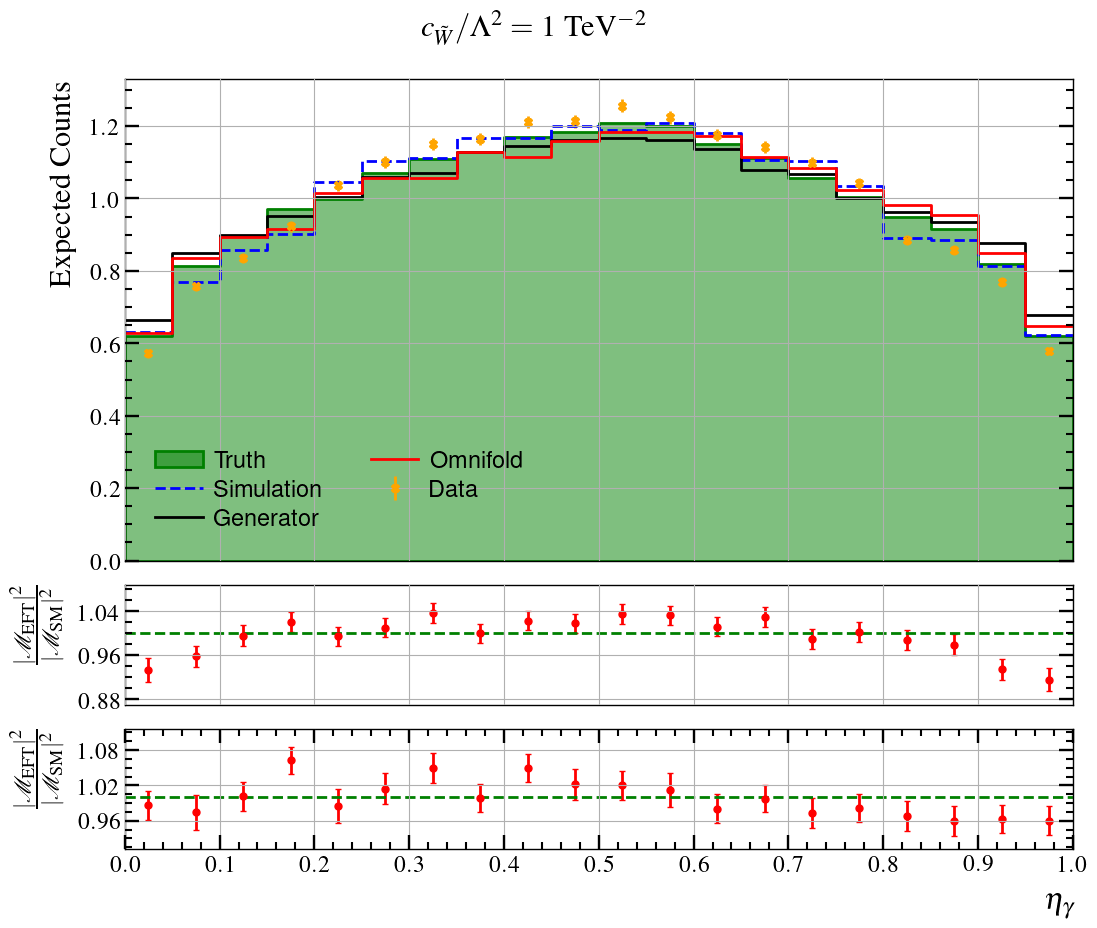

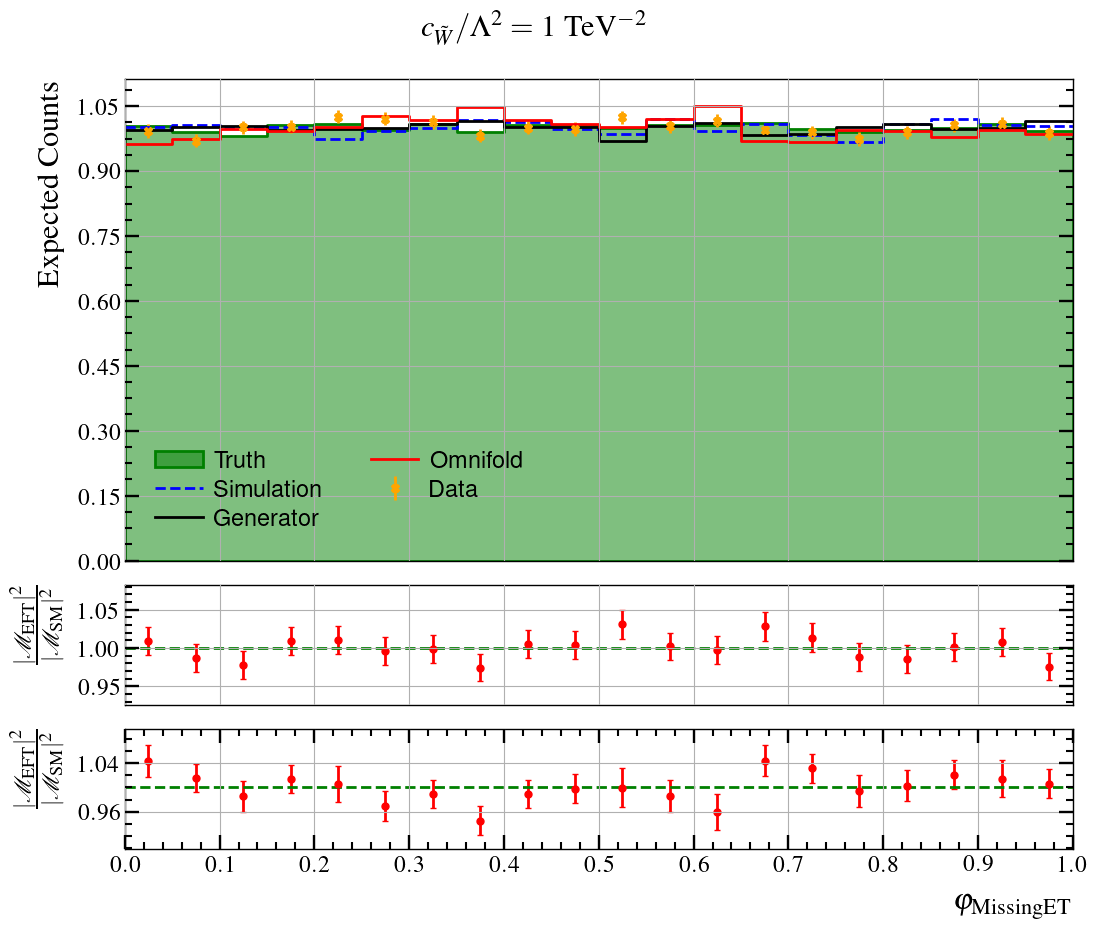

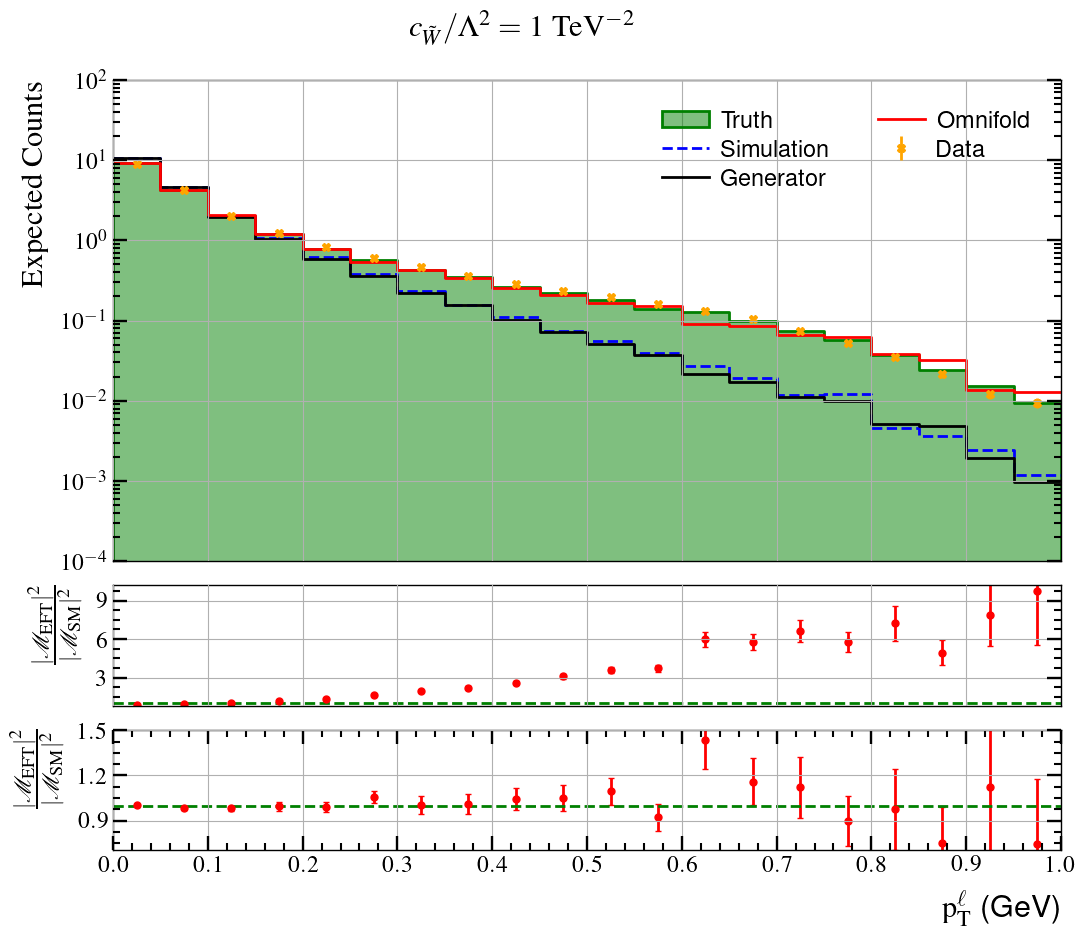

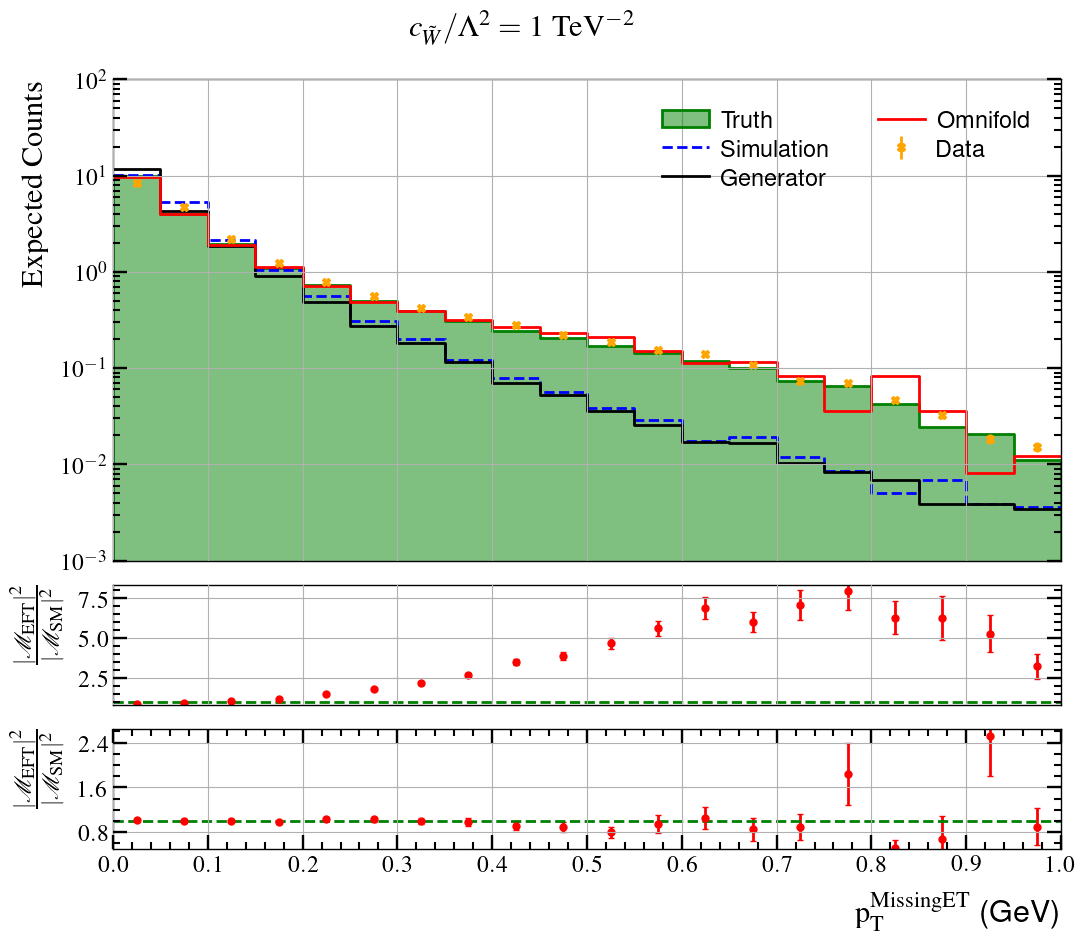

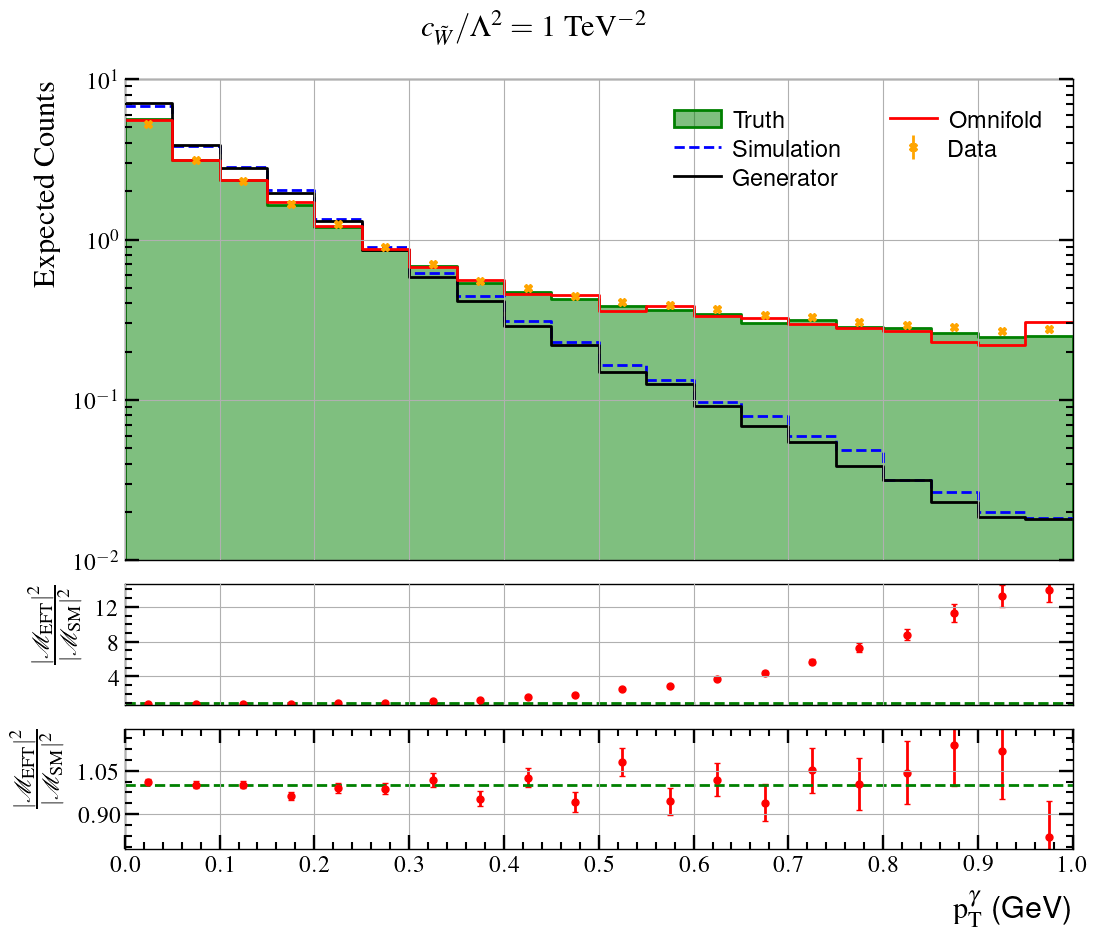

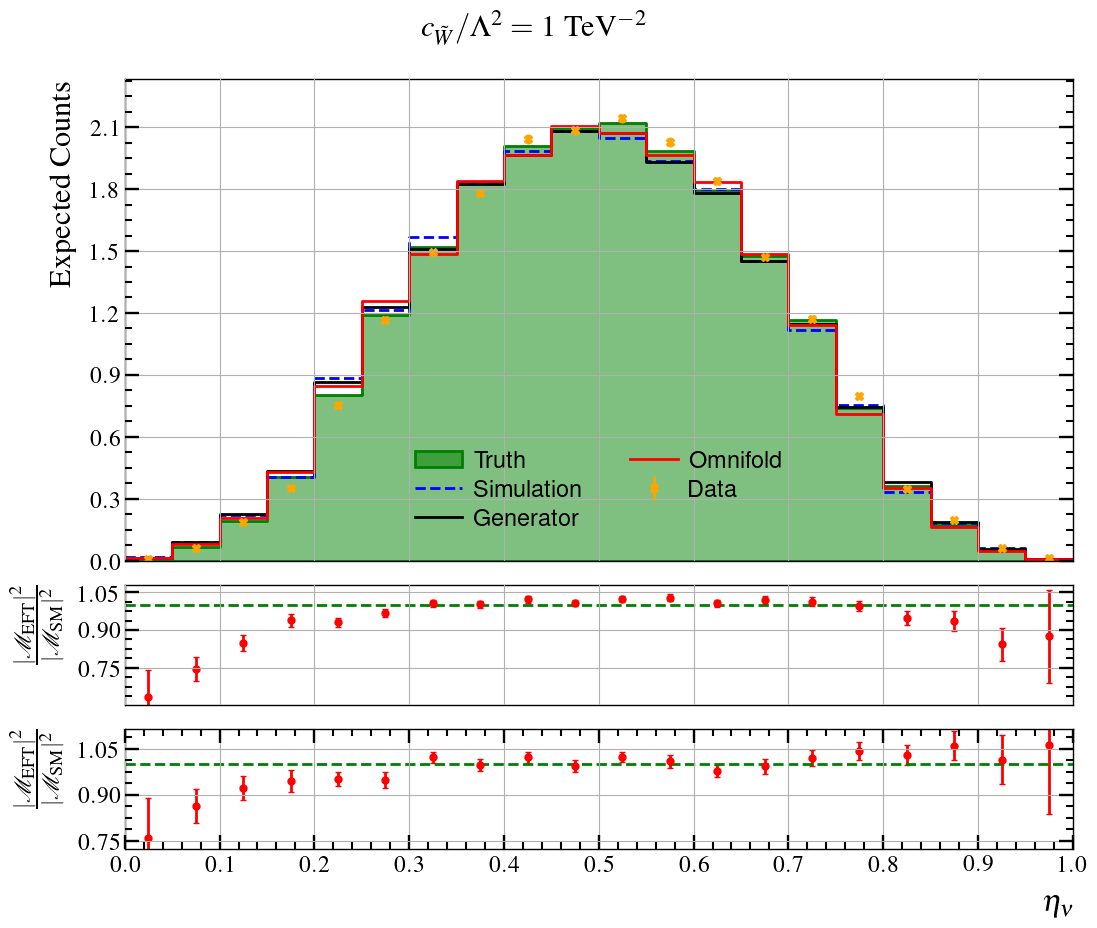

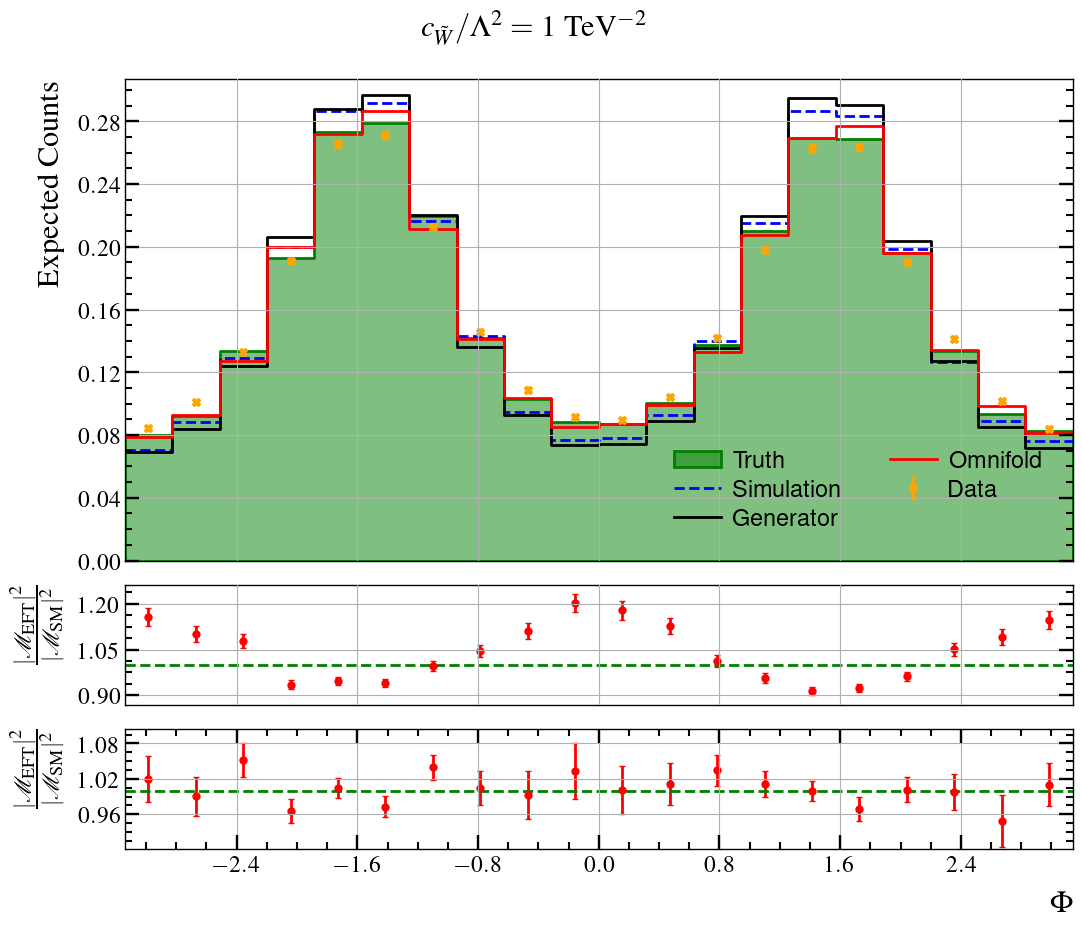

before  8.15223737613913  after  0.47171817251618126


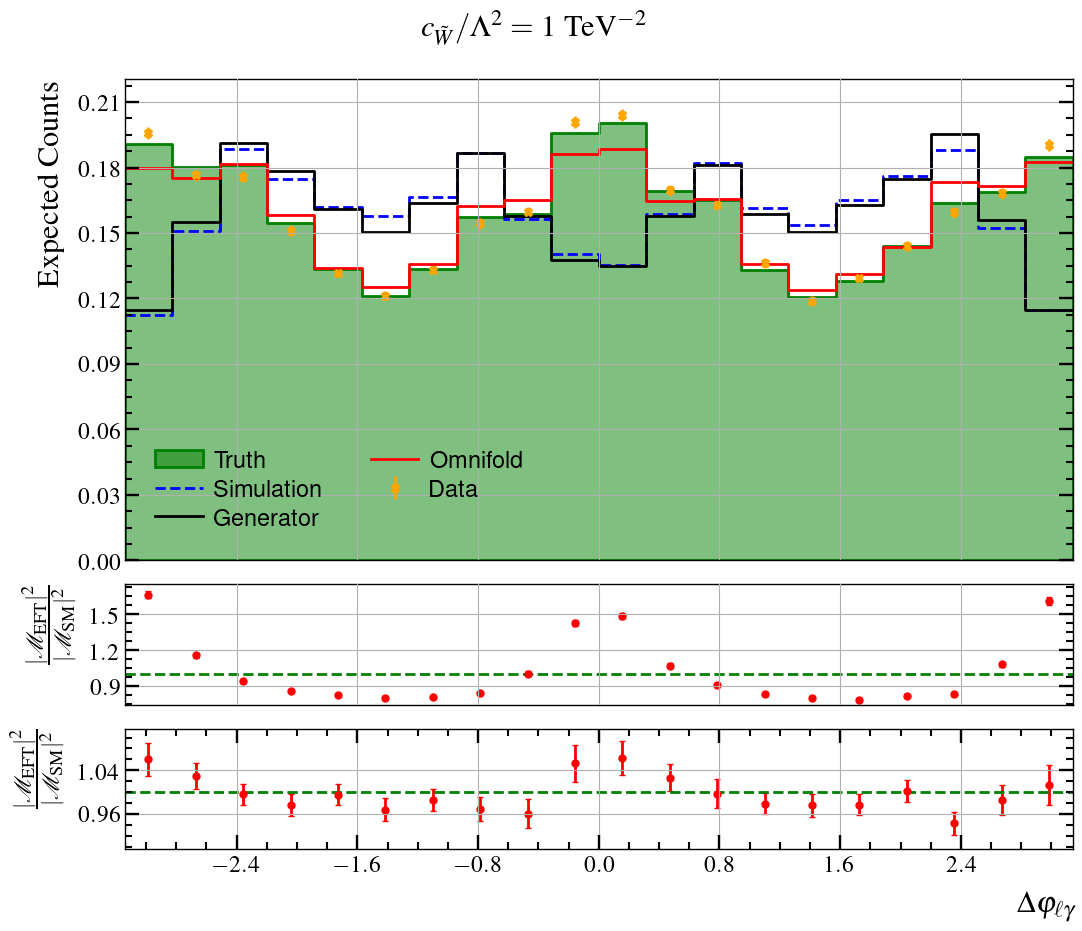

before  64.35387778502916  after  0.8352591111152954


In [87]:
bin_range={'Lepton.PT':[0,200],'Photon.PT':[0,200],
           'Lepton.Eta':[-2.5,2.5],'Photon.Eta':[-2.5,2.5],
           'Lepton.Phi':[-np.pi,np.pi],'Photon.Phi':[-np.pi,np.pi],'MissingET.MET':[0,200],'MissingET.Phi':[-np.pi,np.pi]
           }

labels={'Lepton.PT':r"$\mathrm{p_{T}^{\ell}}$",'Photon.PT':r"$\mathrm{p_{T}^{\gamma}}$",
           'Lepton.Eta':r"$\mathrm{\eta_{\ell}}$",'Photon.Eta':r"$\mathrm{\eta}_{\gamma}$",
           'Lepton.Phi':r"$\mathrm{\varphi_{\ell}}$",'Photon.Phi':r"$\mathrm{\varphi}_{\gamma}$",'MissingET.MET':r"$\mathrm{p^{MissingET}_{T}}$",'MissingET.Phi':r"$\mathrm{\varphi_{MissingET}}$",
           'phi':r"$\Phi$",'dPhi':r"$\mathrm{\Delta\varphi_{\ell \gamma}}$",'Eta_v':r"$\mathrm{\eta_{\nu}}$"
           }

hep.style.use('ATLAS')
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import LogLocator, ScalarFormatter
import pickle


from hist_plot import hist_plot


hep.style.use("ATLAS")
plt.rcParams["text.usetex"] = True

plt.rcParams.update({
    "font.size": 16,  # Base font size
    "axes.labelsize": 22,  # Axis labels
    "axes.titlesize": 20,  # Plot title
    "xtick.labelsize": 17,  # X-axis tick labels
    "ytick.labelsize": 17,  # Y-axis tick labels
    "legend.fontsize": 20,  # Legend font size
    "figure.titlesize": 22,  # Overall figure title
})
plt.rcParams.update({
    "legend.fontsize": 17,  # Legend font size
    "legend.title_fontsize": 16,  # Legend title font size
})
plt.rcParams.update({
    "xtick.major.size": 10,  # Major tick size (length)
    "ytick.major.size": 10,
    "xtick.minor.size": 5,   # Minor tick size
    "ytick.minor.size": 5,
    "xtick.major.width": 1.7,  # Major tick width
    "ytick.major.width": 1.7,
    "xtick.minor.width": 1.5,  # Major tick width
    "ytick.minor.width": 1.5,
})

for var in unfold_vars+['phi','dPhi']:
    
    sim_det_temp=data_sets['SM']['detector'][var]
    sim_part_temp=data_sets['SM']['particle'][var]
    data_det_temp=data_sets['EFT_NP1']['detector'][var]
    data_part_temp=data_sets['EFT_NP1']['particle'][var]

    omni_weights=w_push*sim_const


    fig=plt.figure(figsize=[12,10])

    gs=plt.GridSpec(3,1,height_ratios=[24,6,6],hspace=0.3)
    

    ax1=fig.add_subplot(gs[0])


    result_data_det_temp=hist_plot(data=data_det_temp,weights=data_sets['EFT_NP1']['weights_detector'],bins=20,constant=data_sets['EFT_NP1']['constant'],weights_full=data_sets['EFT_NP1']['weights_full'])


    ax1.errorbar(result_data_det_temp['centres'],unp.nominal_values(result_data_det_temp['expected_norm']),yerr=unp.std_devs(result_data_det_temp['expected_norm']),fmt='X',linestyle=None,markersize=6,label='Data',color='orange')



    ax1=sns.histplot(x=data_part_temp,bins=20,fill='green',element='step',lw=2,label='Truth',stat='density',
                     color='green',alpha=0.5,weights=data_sets['EFT_NP1']['weights_particle']*data_sets['EFT_NP1']['constant'])
    
    ax1=sns.histplot(x=sim_det_temp,bins=20,fill=None,element='step',lw=2,label='Simulation',stat='density',
                weights=data_sets['SM']['weights_detector']*data_sets['SM']['constant'],color='blue',linestyle='--')
    
    ax1=sns.histplot(x=sim_part_temp,bins=20,fill=None,element='step',lw=2,label='Generator',stat='density',
                     color='black',
                     weights=data_sets['SM']['weights_particle']*data_sets['SM']['constant']
                     )
    ax1=sns.histplot(x=sim_part_temp,bins=20,fill=None,element='step',lw=2,label='Omnifold',
                     color='red',stat='density',
                     weights=omni_weights
                     )
    
    
    
    result_sim_part_temp=hist_plot(data=sim_part_temp,weights=data_sets['SM']['weights_particle'],bins=20,constant=data_sets['SM']['constant'],weights_full=data_sets['SM']['weights_full'])
    


    result_data_part_temp=hist_plot(data=data_part_temp,weights=data_sets['EFT_NP1']['weights_particle'],bins=20,constant=data_sets['EFT_NP1']['constant'],weights_full=data_sets['EFT_NP1']['weights_full'])



    result_sim_part_temp_omni=hist_plot(data=sim_part_temp,weights=w_push,bins=20,constant=data_sets['SM']['constant'],weights_full=data_sets['SM']['weights_full'])

    metric_omni=error_propagation(result_data_part_temp['expected_norm'],'/',result_sim_part_temp_omni['expected_norm'])
    



    metric=error_propagation(result_data_part_temp['expected_norm'],'/',result_sim_part_temp['expected_norm'])
    if (var[-2:] == 'PT') or (var[-2:] == 'ET'):
        ax1.set_yscale('log')
    

    else:
        ax1.set_ylim(max([0,0]),max(unp.nominal_values(result_data_part_temp['expected_norm']))*1.1)
        ax1.yaxis.set_major_locator(MaxNLocator(nbins=8))
    ax1.set_ylabel(r"$\mathrm{Expected  \ Counts}$")
    ax1.set_xlabel('')
    ax1.set_xticks([])
    ax1.grid()
    
    ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    

    gs.update(hspace=0.1)
    ax2=fig.add_subplot(gs[1],sharex=ax1)
    

    ax2.errorbar(result_data_det_temp['centres'],unp.nominal_values(metric),yerr=unp.std_devs(metric),color='red',markersize=5,fmt='o',linestyle=None,capsize=2)
    ax2.grid()
    ax2.set_ylabel( r" $  \mathrm{  \frac{ | \mathcal{M}_{EFT} |^{2}  }{| \mathcal{M}_{SM} |^{2} }  }     $  "  )
    if (var[-2:] == 'PT') or (var[-2:] == 'ET'):
        unit=' (GeV)'
    
    else:
        unit=''
    #ax2.set_xlabel(labels[var]+unit)
    ax2.axhline(1,lw=2,ls='--',color='green')
    #ax2.set_xticks(result_data_det_temp['centres'])
    ax2.set_ylim(0.95*np.min(unp.nominal_values(metric)),1.05*np.max(unp.nominal_values(metric)))
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=4))
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=10))
    ax2.set_xlabel('')
    ax2.set_xticks([])
    ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)


    ax1.legend(
    loc="best",           # Position of the legend
    handletextpad=0.5,    # Space between legend markers and labels
    labelspacing=0.3,     # Vertical space between legend entries
    borderaxespad=0.3,    # Padding between legend and axes
    ncol=2                # Arrange legends in 2 columns
)   
    

    ax3=fig.add_subplot(gs[2],sharex=ax1)
    

    ax3.errorbar(result_data_det_temp['centres'],unp.nominal_values(metric_omni),yerr=unp.std_devs(metric_omni),color='red',markersize=5,fmt='o',linestyle=None,capsize=2)
    ax3.grid()
    ax3.set_ylabel( r" $  \mathrm{  \frac{ | \mathcal{M}_{EFT} |^{2}  }{| \mathcal{M}_{SM} |^{2} }  }     $  "  )
    if (var[-2:] == 'PT') or (var[-2:] == 'ET'):
        unit=' (GeV)'
    
    else:
        unit=''
    ax3.set_xlabel(labels[var]+unit)
    ax3.axhline(1,lw=2,ls='--',color='green')
    ax3.set_xticks(result_data_det_temp['centres'])
    ax3.set_ylim(0.95*np.min(unp.nominal_values(metric_omni)),1.05*np.max(unp.nominal_values(metric_omni)))
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=4))
    ax3.xaxis.set_major_locator(MaxNLocator(nbins=10))

    max_y_ax3 = ax3.get_ylim()[1]
    #ax1.plot([],[],label=r"$c_{\tilde{W}}$")
  
   

    plt.suptitle(r"$c_{\tilde{W}}/\Lambda^{2}=1 \ \mathrm{TeV^{-2}}$",y=1)
   
    var_prime=var.replace(".", "_")
    
    #plt.savefig('/Users/claudiumihai/MPhys/Analysis/Workflow/Pre_Omnifold/ValidationPlots/NoUnfolding/cw/'+var_prime+'.png',dpi=800)
    
    plt.show()
    if (var=='dPhi') or (var=='phi'):
        chi=np.sum( (np.square(unp.nominal_values(metric)-1))/unp.std_devs(metric) )
        chi_omni=np.sum( (np.square(unp.nominal_values(metric_omni)-1))/unp.std_devs(metric_omni) )
        print('before ',chi,' after ',chi_omni)
    

    

In [89]:
data_part

,Unnamed: 0,Muon.PT,Muon.Phi,Muon.Eta,Muon.Charge,Electron.PT,Electron.Phi,Electron.Eta,Electron.Charge,MissingET.MET_recon,...,Lepton.Phi,coin_flip,large_boost,delta,sign,Eta_v,Phi,phi,phi_true,dPhi
0,2,NaN,NaN,NaN,NaN,43.324909,-1.729296,1.748492,-1.0,54.140434,...,0.224770,0.543776,2.753707,0.989671,1.0,0.550625,0.0,0.666812,0.669664,-0.400894
1,5,59.463928,0.219137,-1.459783,-1.0,NaN,NaN,NaN,NaN,52.178060,...,0.534875,0.171785,2.081784,0.605782,1.0,0.450300,0.0,-0.571875,-0.575678,2.182566
2,6,115.517052,-0.701115,-0.995478,1.0,NaN,NaN,NaN,NaN,42.648846,...,0.388411,0.004249,1.318365,0.112130,1.0,0.436298,0.0,2.026664,2.880569,1.825973
3,11,NaN,NaN,NaN,NaN,57.396240,0.689073,-2.460292,-1.0,90.242270,...,0.609668,0.054825,1.247049,0.612321,1.0,0.332228,0.0,0.140106,0.139829,-0.085732
4,18,NaN,NaN,NaN,NaN,61.554775,-2.383636,-0.792583,1.0,79.480920,...,0.120628,0.949351,1.278964,0.084599,1.0,0.356243,0.0,1.163703,2.476852,-0.624579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168241,499977,96.989059,2.180190,1.143786,1.0,NaN,NaN,NaN,NaN,63.836864,...,0.846989,0.561389,1.043237,-0.820628,-1.0,0.634408,0.0,-1.917137,-1.719876,0.729398
168242,499989,44.555828,1.095996,-1.213927,1.0,NaN,NaN,NaN,NaN,81.852740,...,0.674433,0.606408,1.771085,-1.003692,-1.0,0.354719,0.0,1.271968,0.874957,1.107745
168243,499993,NaN,NaN,NaN,NaN,39.587936,-1.351472,2.496989,1.0,52.409992,...,0.284903,0.000204,3.113151,0.134237,1.0,0.855733,0.0,-1.367861,-1.649169,-1.008918
168244,499994,NaN,NaN,NaN,NaN,91.359116,1.058890,-0.920237,-1.0,53.932310,...,0.668527,0.490707,1.310920,-1.097207,-1.0,0.389558,0.0,1.134962,0.987764,0.873837


before  0.9095112526032734  after  0.13644243073631304


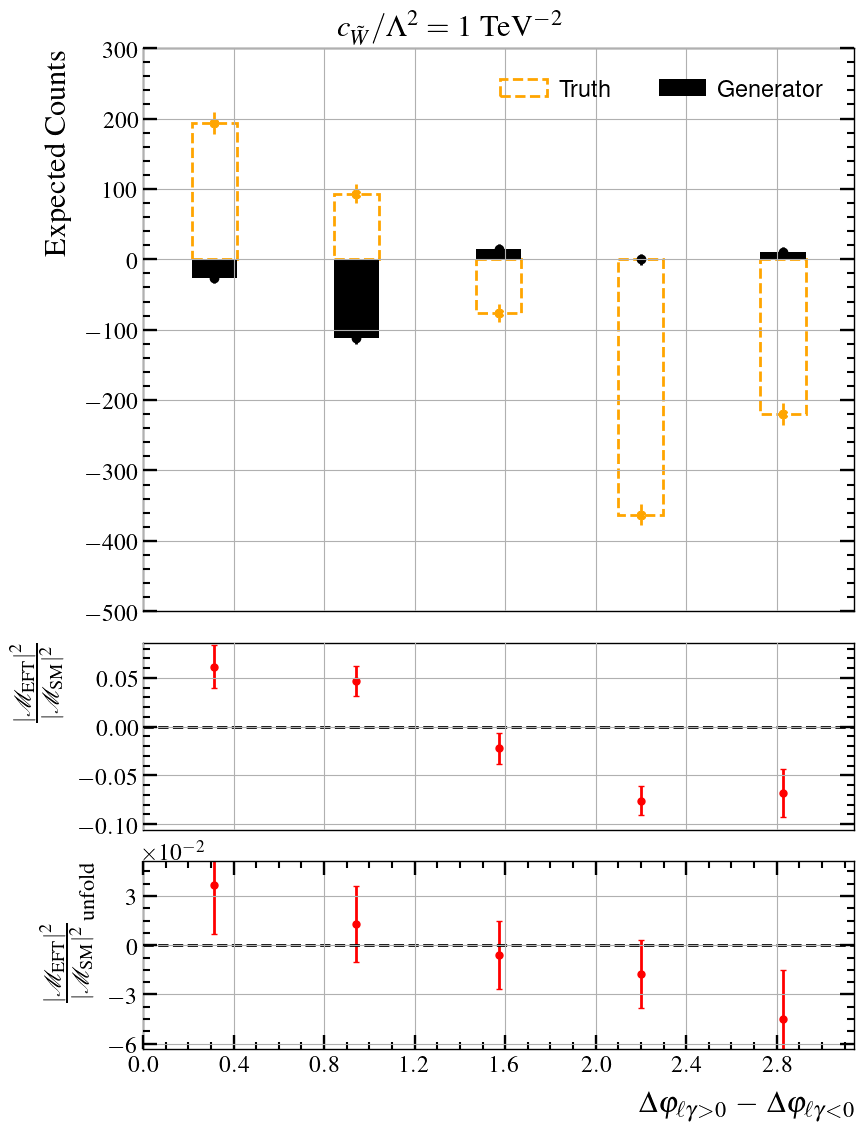

before  0.19648683991410154  after  0.058893072028713335


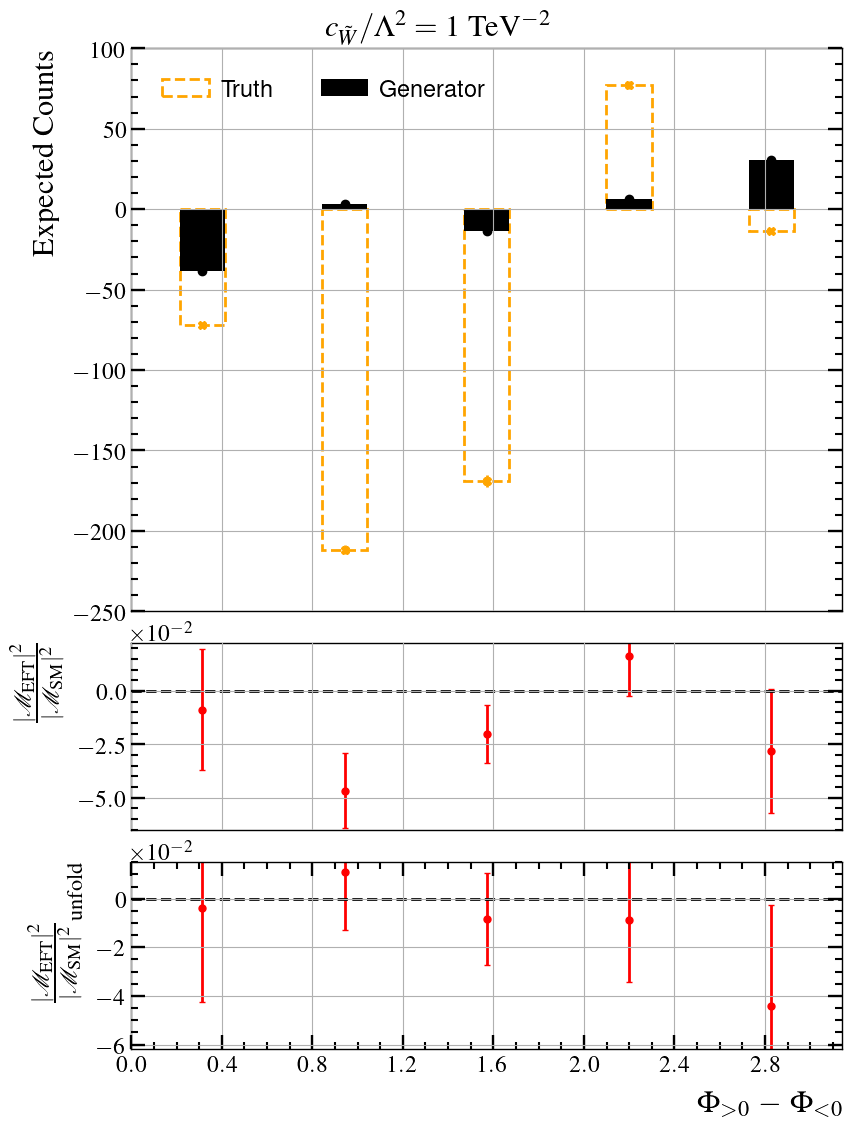

In [90]:
bin_range={'Lepton.PT':[0,200],'Photon.PT':[0,200],
           'Lepton.Eta':[-2.5,2.5],'Photon.Eta':[-2.5,2.5],
           'Lepton.Phi':[-np.pi,np.pi],'Photon.Phi':[-np.pi,np.pi],'MissingET.MET':[0,200],'MissingET.Phi':[-np.pi,np.pi]
           }

labels={'Lepton.PT':r"$\mathrm{p_{T}^{\ell}}$",'Photon.PT':r"$\mathrm{p_{T}^{\gamma}}$",
           'Lepton.Eta':r"$\mathrm{\eta_{\ell}}$",'Photon.Eta':r"$\mathrm{\eta}_{\gamma}$",
           'Lepton.Phi':r"$\mathrm{\varphi_{\ell}}$",'Photon.Phi':r"$\mathrm{\varphi}_{\gamma}$",'MissingET.MET':r"$\mathrm{p^{MissingET}_{T}}$",'MissingET.Phi':r"$\mathrm{\varphi_{MissingET}}$",
           'phi':r"$\Phi$",'dPhi':r"$\mathrm{\Delta\varphi_{\ell \gamma}}$"
           }

hep.style.use('ATLAS')
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import LogLocator, ScalarFormatter
import pickle

"""data_sets={'SM':{'particle':SM_part,'detector':SM_det,'weights_detector':SM_det['Event.Weight'],'weights_particle':SM_part['Event.Weight'],'constant':SM_const,'weights_full':w_full_sm},
           'EFT_NP1':{'particle':NP1_part,'detector':NP1_det,'weights_detector':NP1_det['Event.Weight'],'weights_particle':NP1_part['Event.Weight'],'constant':NP1_const,'weights_full':w_full_np1},
           'EFT_NP2_1':{'particle':NP2_1_part,'detector':NP2_1_det,'weights_detector':NP2_1_det['Event.Weight'],'weights_particle':NP2_1_part['Event.Weight'],'constant':NP2_1_const,'weights_full':w_full_np2_1},
           'EFT_NP2_2':{'particle':NP2_2_part,'detector':NP2_2_det,'weights_detector':NP2_2_det['Event.Weight'],'weights_particle':NP2_2_part['Event.Weight'],'constant':NP2_2_const,'weights_full':w_full_np2_2}}
"""
hep.style.use("ATLAS")
plt.rcParams["text.usetex"] = True

plt.rcParams.update({
    "font.size": 16,  # Base font size
    "axes.labelsize": 22,  # Axis labels
    "axes.titlesize": 20,  # Plot title
    "xtick.labelsize": 17,  # X-axis tick labels
    "ytick.labelsize": 17,  # Y-axis tick labels
    "legend.fontsize": 20,  # Legend font size
    "figure.titlesize": 22,  # Overall figure title
})
plt.rcParams.update({
    "legend.fontsize": 17,  # Legend font size
    "legend.title_fontsize": 16,  # Legend title font size
})
plt.rcParams.update({
    "xtick.major.size": 10,  # Major tick size (length)
    "ytick.major.size": 10,
    "xtick.minor.size": 5,   # Minor tick size
    "ytick.minor.size": 5,
    "xtick.major.width": 1.7,  # Major tick width
    "ytick.major.width": 1.7,
    "xtick.minor.width": 1.5,  # Major tick width
    "ytick.minor.width": 1.5,
})
raio_test=[]
ratio_test_ommni=[]
for var in ['dPhi','phi']:
    
   
    omni_weights=w_push*sim_const

    result_sm= hist_plot(sim_part[var],sim_part['Event.Weight'],10,sim_const,w_full_sm)
    expected_yield_sm,expected_yield_norm_sm,bin_centres_sm = result_sm['expected'],result_sm['expected_norm'],result_sm['centres']


    result_np1= hist_plot(data_part[var],data_part['Event.Weight'],10,data_const,w_full_np1)
    expected_yield_np1,expected_yield_norm_np1,bin_centres_np1 = result_np1['expected'],result_np1['expected_norm'],result_np1['centres']

    
    result_sm_omni= hist_plot(sim_part[var],w_push,10,sim_const,w_full_sm)
    expected_yield_sm_omni,expected_yield_norm_sm_omni,bin_centres_sm_omni = result_sm_omni['expected'],result_sm_omni['expected_norm'],result_sm_omni['centres']



    ratio_omni=error_propagation(expected_yield_norm_np1,'/',expected_yield_norm_sm_omni)

    ratio=error_propagation(expected_yield_norm_np1,'/',expected_yield_norm_sm)

    asym=error_propagation(ratio[bin_centres_np1>0],'-',ratio[bin_centres_np1<0][::-1])

    asym_omni=error_propagation(ratio_omni[bin_centres_np1>0],'-',ratio_omni[bin_centres_np1<0][::-1])



    #raio_test.append(ratio)
    #ratio_test_ommni.append(ratio_omni)
    fig=plt.figure(figsize=[9,13])

    gs=plt.GridSpec(3,1,height_ratios=[33,11,11],hspace=0.3)
    

    ax1=fig.add_subplot(gs[0])

    diff_data_part=error_propagation(expected_yield_np1[bin_centres_np1>0],'-',expected_yield_np1[bin_centres_np1<0][::-1])

    ax1.errorbar(bin_centres_np1[bin_centres_np1>0],unp.nominal_values(diff_data_part),yerr=unp.std_devs(diff_data_part),fmt='X',linestyle=None,markersize=6,color='orange')

    ax1.bar(bin_centres_np1[bin_centres_np1>0],unp.nominal_values(diff_data_part),label='Truth',edgecolor='orange',width=0.2,facecolor='none',linestyle='--',linewidth=2)

    diff_sim_part=error_propagation(expected_yield_sm[bin_centres_sm>0],'-',expected_yield_sm[bin_centres_sm<0][::-1])


    ax1.errorbar(bin_centres_sm[bin_centres_sm>0],unp.nominal_values(diff_sim_part),yerr=unp.std_devs(diff_sim_part),fmt='o',linestyle=None,markersize=6,color='black')

    ax1.bar(bin_centres_sm[bin_centres_sm>0],unp.nominal_values(diff_sim_part),label='Generator',color='black',width=.2)


    """ax1=sns.histplot(x=data_part,bins=20,fill='green',element='step',lw=2,label='Truth',stat='count',
                     color='green',alpha=0.5,weights=data_sets['EFT_NP1']['weights_particle']*data_sets['EFT_NP1']['constant'])
    
    ax1=sns.histplot(x=sim_det,bins=20,fill=None,element='step',lw=2,label='Simulation',stat='count',
                weights=data_sets['SM']['weights_detector']*data_sets['SM']['constant'],color='blue',linestyle='--')
    
    ax1=sns.histplot(x=sim_part,bins=20,fill=None,element='step',lw=2,label='Generator',stat='count',
                     color='black',
                     weights=data_sets['SM']['weights_particle']*data_sets['SM']['constant']
                     )"""
    #ax1=sns.histplot(x=sim_part,bins=20,fill=None,element='step',lw=2,label='Omnifold',
    #                 color='red',
    #                 #
    #                 weights=omni_weights
    #                 )
    
    
    
    #result_sim_part=hist_plot(data=sim_part,weights=data_sets['SM']['weights_particle'],bins=20,constant=data_sets['SM']['constant'],weights_full=data_sets['SM']['weights_full'])
    
    
    #result_data_part=hist_plot(data=data_part,weights=data_sets['EFT_NP1']['weights_particle'],bins=20,constant=data_sets['EFT_NP1']['constant'],weights_full=data_sets['EFT_NP1']['weights_full'])

    
    
   # metric=error_propagation(result_data_part['expected'],'/',result_sim_part['expected'])

    metric=asym
    metric_omni=asym_omni

    #if (var[-2:] == 'PT') or (var[-2:] == 'ET'):
    #    ax1.set_yscale('log')
    #    ax1.yaxis.set_major_locator(LogLocator())
    
    #else:
    ax1.set_ylabel(r"$\mathrm{Expected  \ Counts}$")
    #ax1.set_ylim(max([0,0]),max(unp.nominal_values(diff_data_part))*1.1)
    ax1.yaxis.set_major_locator(MaxNLocator(nbins=8))
    ax1.set_xlim(0,np.pi)
    ax1.set_xlabel('')
    ax1.set_xticks([])
    ax1.grid()
    
    ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    

    gs.update(hspace=0.1)
    ax2=fig.add_subplot(gs[1],sharex=ax1)
    

    ax2.errorbar(bin_centres_sm[bin_centres_sm>0],unp.nominal_values(metric),yerr=unp.std_devs(metric),color='red',markersize=5,fmt='o',linestyle=None,capsize=2)
    ax2.grid()
    ax2.set_ylabel( r" $  \mathrm{  \frac{ | \mathcal{M}_{EFT} |^{2}  }{| \mathcal{M}_{SM} |^{2} }  }     $  "  )
    if (var[-2:] == 'PT') or (var[-2:] == 'ET'):
        unit=' (GeV)'
    
    else:
        unit=''
    #ax2.set_xlabel(labels[var]+unit)
    ax2.axhline(0,lw=2,ls='--',color='black')
    #ax2.set_xticks(result_data_det['centres'])
    ax2.set_ylim(1.4*np.min(unp.nominal_values(metric)),1.4*np.max(unp.nominal_values(metric)))
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=5))
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=10))
    ax2.set_xlabel('')
    #ax2.set_xlim(0,np.pi)
    ax2.set_xticks([])
    ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)


    ax1.legend(
    loc="best",           # Position of the legend
    handletextpad=0.5,    # Space between legend markers and labels
    labelspacing=0.3,     # Vertical space between legend entries
    borderaxespad=0.3,    # Padding between legend and axes
    ncol=2                # Arrange legends in 2 columns
)   
    

    ax3=fig.add_subplot(gs[2],sharex=ax1)
    

    ax3.errorbar(bin_centres_sm[bin_centres_sm>0],unp.nominal_values(metric_omni),yerr=unp.std_devs(metric_omni),color='red',markersize=5,fmt='o',linestyle=None,capsize=2)
    ax3.grid()
    ax3.set_ylabel( r" $  \mathrm{  \frac{ | \mathcal{M}_{EFT} |^{2}  }{| \mathcal{M}_{SM} |^{2} }_{unfold}  }     $  "  )
    if (var[-2:] == 'PT') or (var[-2:] == 'ET'):
        unit=' (GeV)'
    
    else:
        unit=''
    ax3.set_xlabel(labels[var]+r'$_{>0}$'+r"$ \ - \ $"+labels[var]+r'$_{<0}$')
    ax3.axhline(0,lw=2,ls='--',color='black')
    #ax3.set_xticks(result_data_det['centres'])
    #ax3.set_xlim(0,np.pi)
    ax3.set_ylim(1.4*np.min(unp.nominal_values(metric_omni)),1.4*np.max(unp.nominal_values(metric_omni)))
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=5))
    
    ax3.xaxis.set_major_locator(MaxNLocator(nbins=10))

    max_y_ax3 = ax3.get_ylim()[1]
    #ax1.plot([],[],label=r"$c_{\tilde{W}}$")
  
   

    plt.suptitle(r"$c_{\tilde{W}}/\Lambda^{2}=1\ \mathrm{TeV^{-2}}$",y=0.96)
   
    var_prime=var.replace(".", "_")
    #plt.savefig('/Users/claudiumihai/MPhys/Analysis/Workflow/Pre_Omnifold/ValidationPlots/NoUnfolding/cw/'+var_prime+'.png',dpi=800)

    chi=np.sum( (np.square(unp.nominal_values(metric)-0))/unp.std_devs(metric) )
    chi_omni=np.sum( (np.square(unp.nominal_values(metric_omni)-0))/unp.std_devs(metric_omni) )
    print('before ',chi,' after ',chi_omni)
    
    plt.show()
    

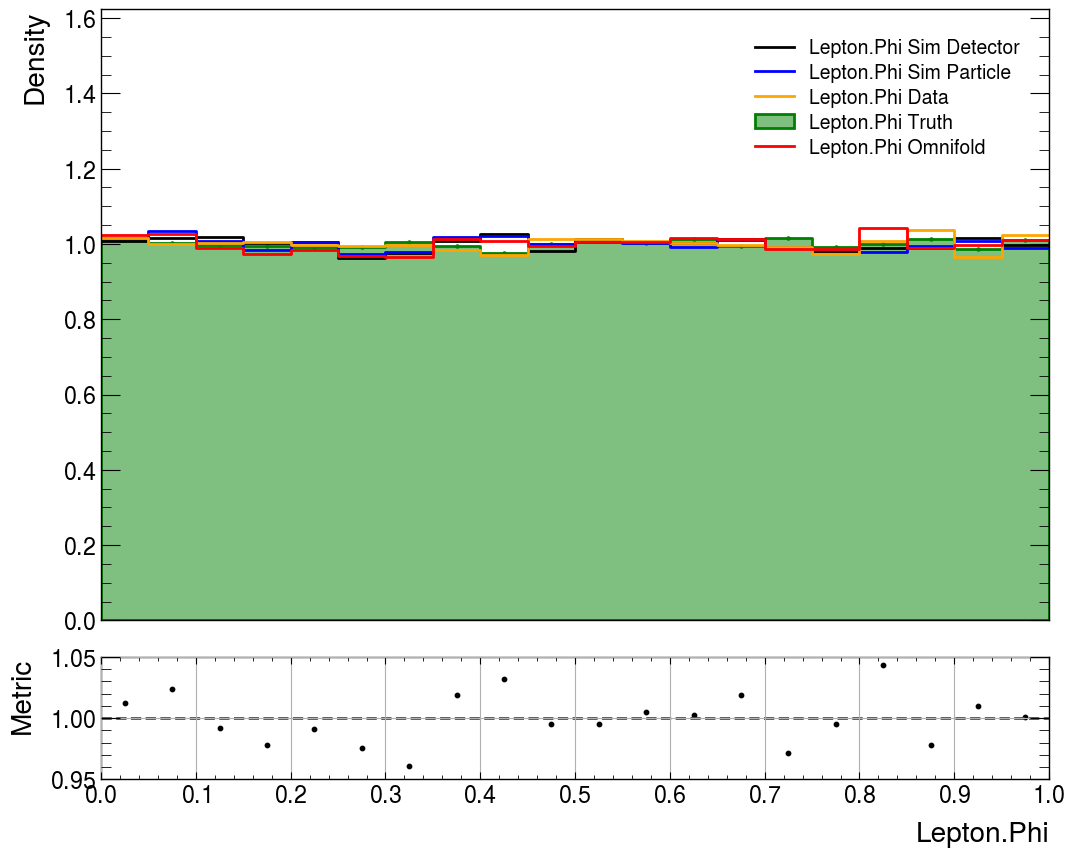

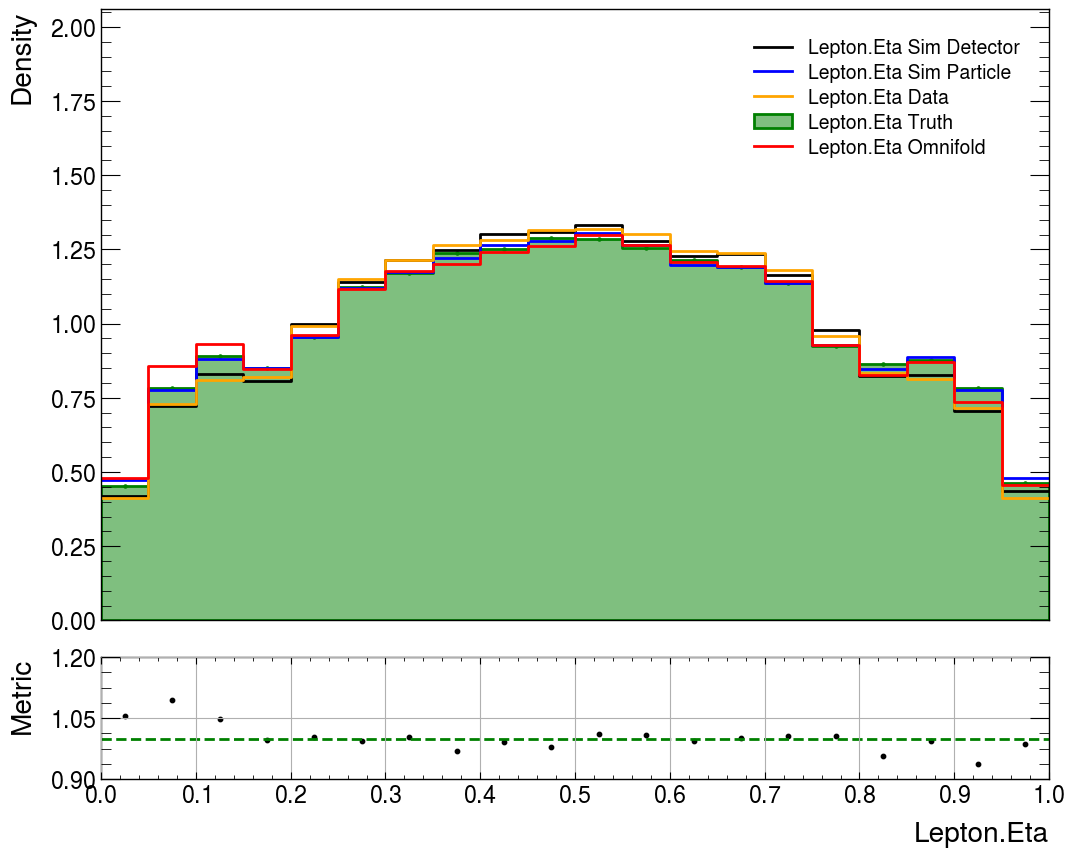

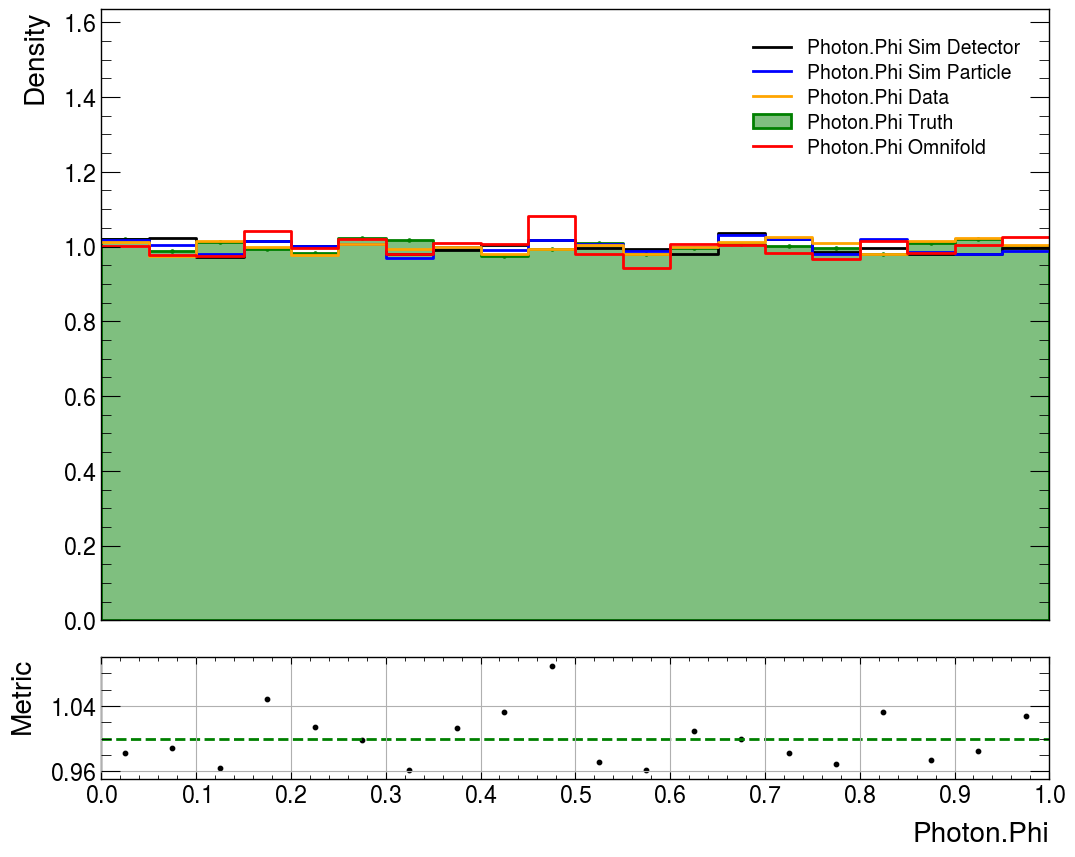

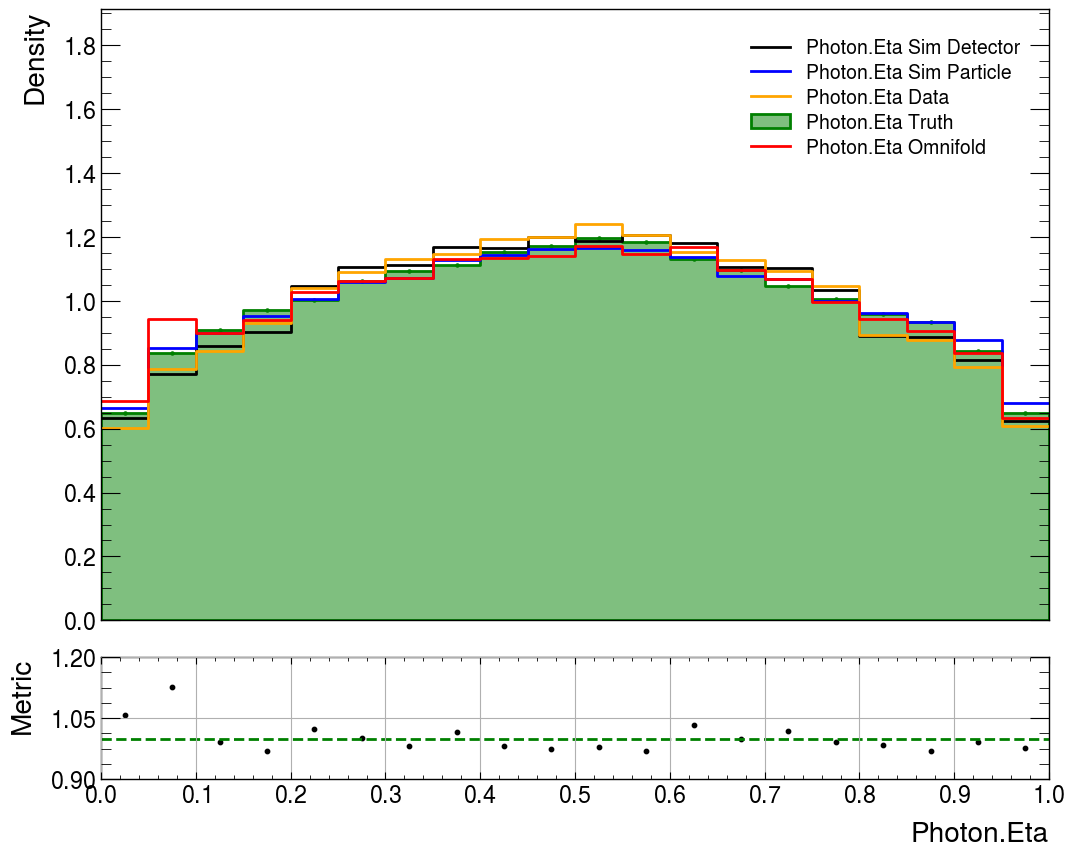

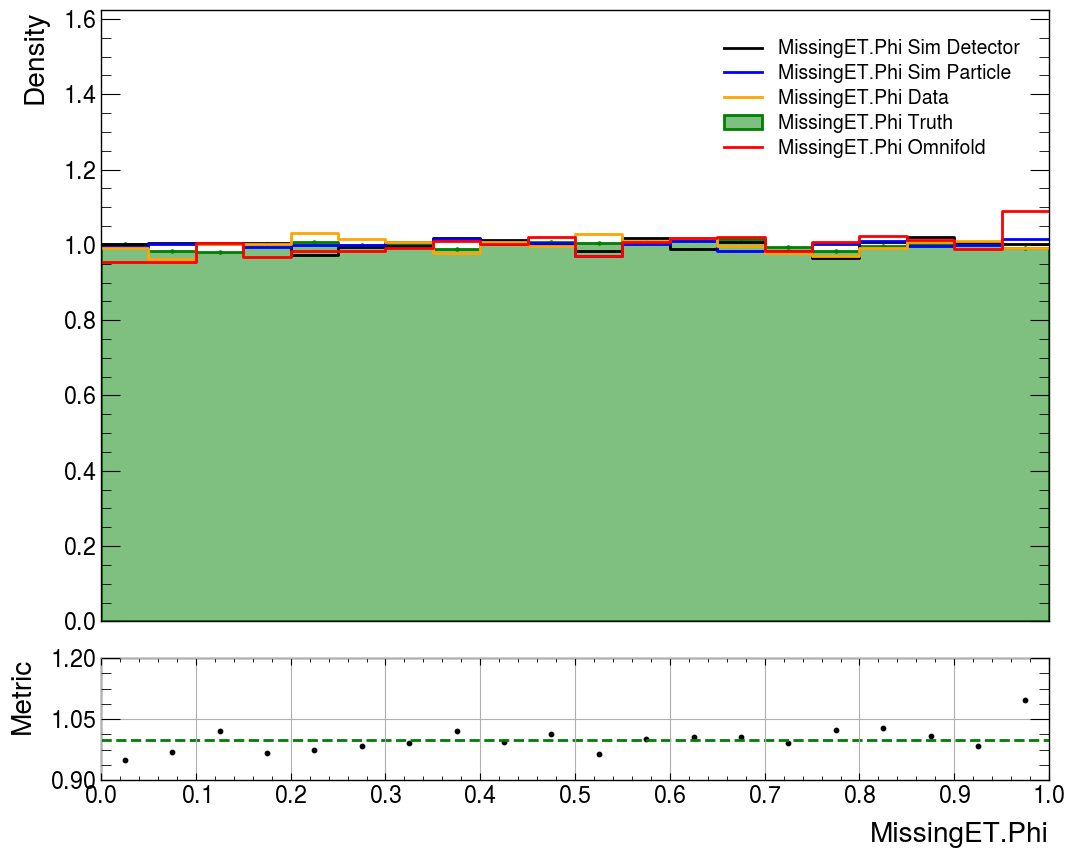

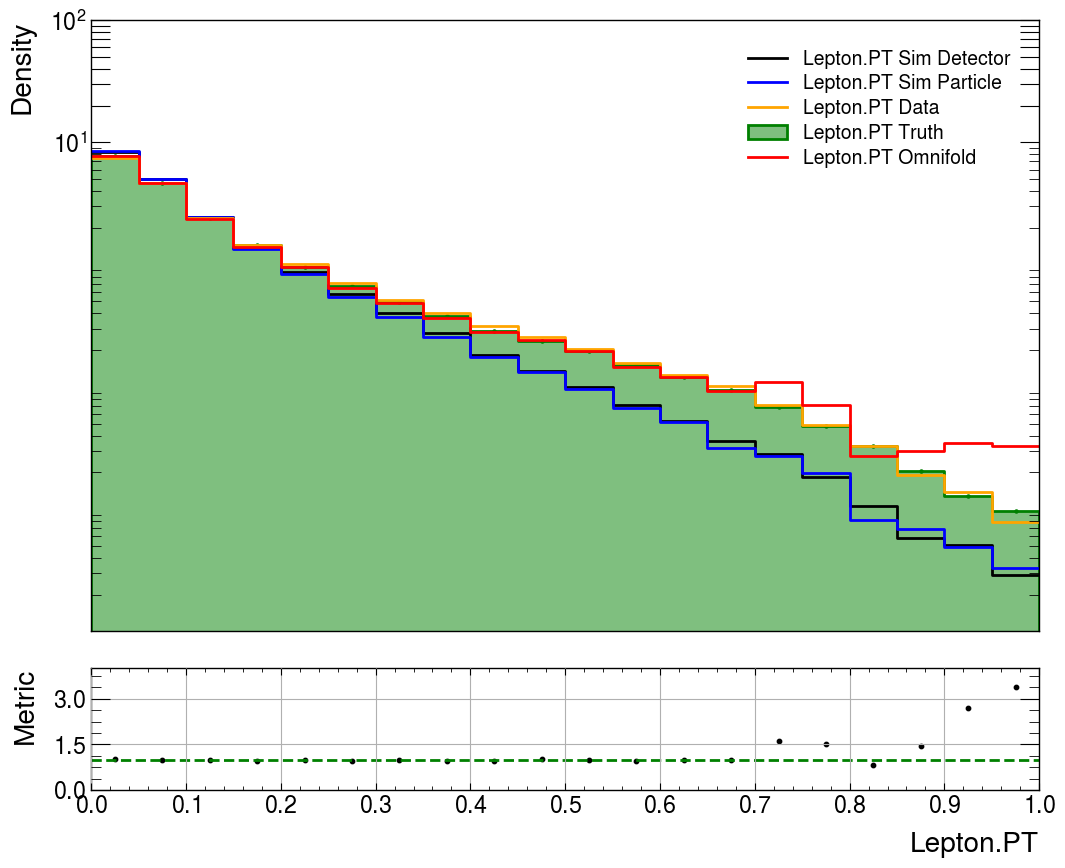

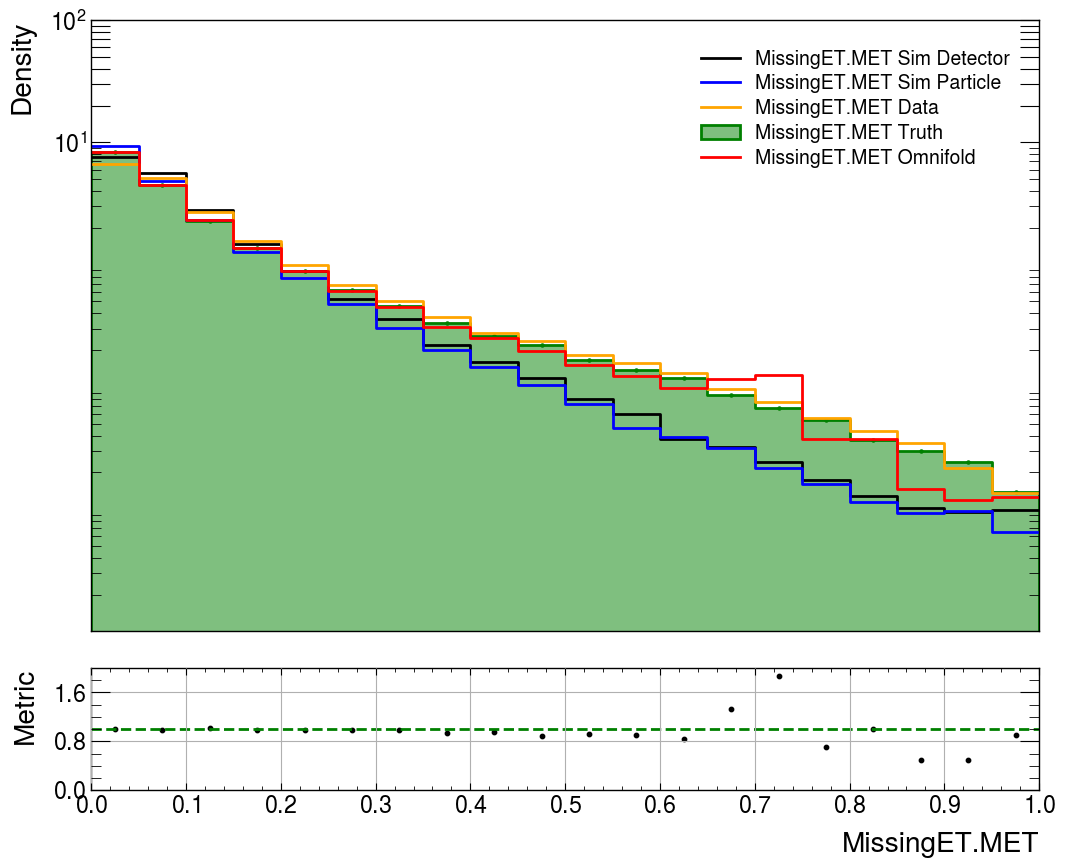

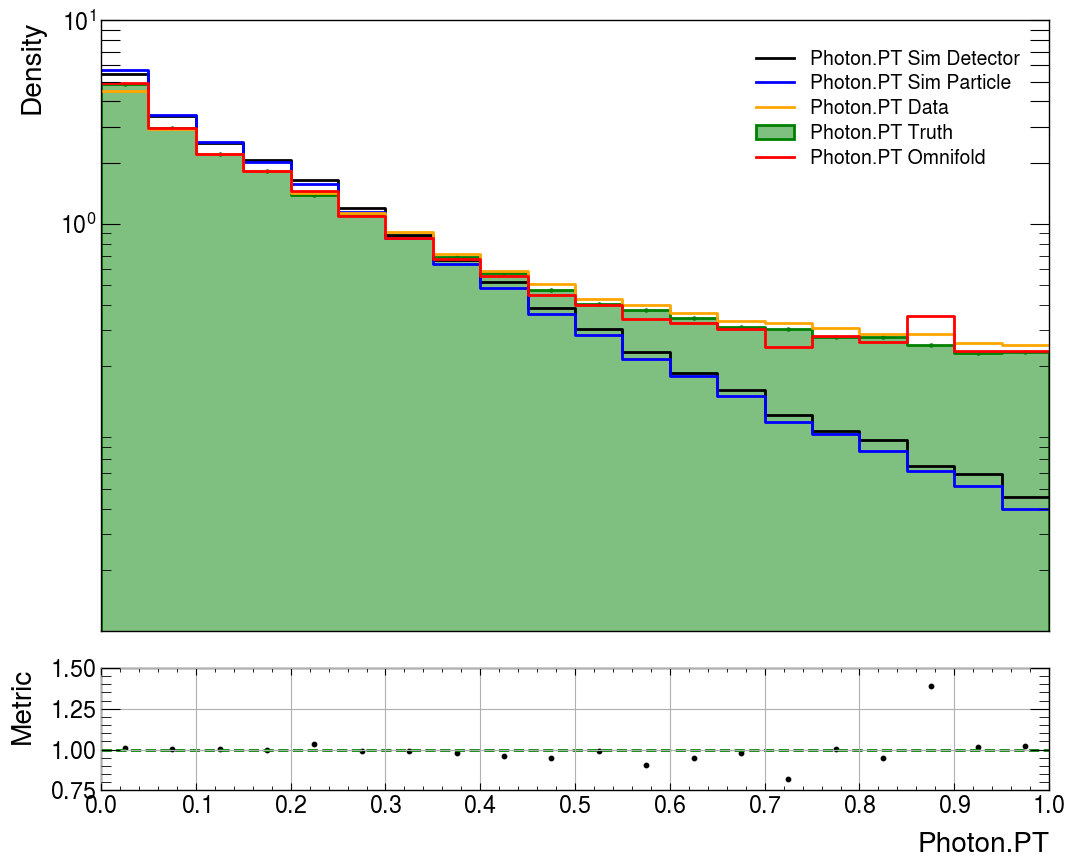

In [315]:
bin_range={'Lepton.PT':[0,200],'Photon.PT':[0,200],
           'Lepton.Eta':[-2.5,2.5],'Photon.Eta':[-2.5,2.5],
           'Lepton.Phi':[-np.pi,np.pi],'Photon.Phi':[-np.pi,np.pi],'MissingET.MET':[0,200],'MissingET.Phi':[-np.pi,np.pi]
           }


hep.style.use('ATLAS')
from matplotlib.ticker import MaxNLocator



loss=[]
for var in unfold_vars:
    """if var[-2:] == 'PT':
        sim_det_temp=sim_det[var][sim_det[var]<200]
        sim_part_temp=sim_part[var][sim_part[var]<200]
        data_det_temp=data_det[var][data_det[var]<200]
        data_part_temp=data_part[var][data_part[var]<200]


        sim_weights=sim_det['Event.Weight'][sim_det[var]<200]
        data_weights=data_det['Event.Weight'][data_det[var]<200]


        part_weight=w_push[sim_part[var]<200]"""
        #print(var)

    #else:
    sim_det_temp=sim_det[var]
    sim_part_temp=sim_part[var]
    data_det_temp=data_det[var]
    data_part_temp=data_part[var]
    sim_weights=sim_det['Event.Weight']
    data_weights=data_det['Event.Weight']

    part_weight=w_push


    fig=plt.figure(figsize=[12,10])
    gs=plt.GridSpec(2,1,height_ratios=[10,2],hspace=0.1)
    fig.subplots_adjust(hspace=0.0)
    

    ax1=fig.add_subplot(gs[0])

    truth_counts, truth_bins=np.histogram( data_part_temp,bins=20,  density=True ,
                                          #range=bin_range[var]
                                          )
    bin_centres = (truth_bins[:-1] + truth_bins[1:])/2.
    bin_widths = truth_bins[1:] - truth_bins[:-1]

    err = err = np.sqrt(truth_counts / bin_widths)
    width = np.sum(truth_bins[1:] - truth_bins[:-1]) / len(bin_centres)


    #print(sim_det_temp.shape,sim_weights.shape)
    sim_counts, sim_bins=np.histogram( sim_part_temp,bins=20  ,density=True,
                                      #range=bin_range[var],
                                      weights=part_weight
                                      )

    metric=sim_counts/(truth_counts)

    loss.append(np.mean(np.abs(1-metric)))

    ax1.scatter(bin_centres,truth_counts,color='green',s=5)

    

   
    


    ax1=sns.histplot(x=sim_det_temp,bins=20,stat='density',fill=None,element='step',lw=2,label=var+' Sim Detector',#binrange=bin_range[var],
                weights=sim_weights,color='black')
    
    ax1=sns.histplot(x=sim_part_temp,bins=20,stat='density',fill=None,element='step',lw=2,label=var+' Sim Particle',#binrange=bin_range[var],
                     color='blue',
                     weights=sim_part['Event.Weight']
                     )
    ax1=sns.histplot(x=data_det_temp,bins=20,stat='density',fill=None,element='step',lw=2,label=var+' Data',#binrange=bin_range[var],
                weights=data_weights,color='orange')
    
    ax1=sns.histplot(x=data_part_temp,bins=20,stat='density',fill='green',element='step',lw=2,label=var+' Truth',#binrange=bin_range[var],
                     color='green',alpha=0.5,weights=data_part['Event.Weight'])
    
    ax1=sns.histplot(x=sim_part_temp,bins=20,stat='density',fill=None,element='step',lw=2,label=var+' Omnifold',#binrange=bin_range[var],
                     color='red',
                     weights=w_push
                     )


    ax1.set_xlabel('')
    ax1.set_xticks([])
    if (var[-2:] == 'PT') or (var[-2:] == 'ET'):
        ax1.set_yscale('log')
    

    else:
        ax1.set_ylim(max([0,0]),max(truth_counts)*1.6)
        ax1.yaxis.set_major_locator(MaxNLocator(nbins=10))
    #ax1.set_ylim(max([0,0]),max(truth_counts)*1.6)
    #ax1.yaxis.set_major_locator(MaxNLocator(nbins=10))
    ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    


    ax2=fig.add_subplot(gs[1],sharex=ax1)
    

    ax2.scatter(bin_centres,metric,color='black',s=10)
    ax2.grid()
    ax2.set_ylabel('Metric')
    ax2.set_xlabel(var)
    #ax2.set_xticks(bin_centres,)
    ax2.axhline(1,lw=2,ls='--',color='green')
    ax2.set_xticks(bin_centres)
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=3))
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=10))
    ax1.legend()    

    max_y_ax2 = ax2.get_ylim()[1]
    #ax1.set_ylim(max_y_ax2_global, max(truth_counts) * 1.4)
    #ax1.set_ylim(max_y_ax2, max(truth_counts) * 1.4) 
    #ax1.set_ylim(0, max(truth_counts) * 1.4)  # Preserve original y-range
    ax1.yaxis.set_major_locator(MaxNLocator(nbins=10))
    #y_ticks = ax1.get_yticks()  # Get current y-ticks
    
    #ax1.set_yticks([tick for tick in y_ticks if tick >= 1]) 

    plt.show()
    

In [579]:
w_push

array([0.916702  , 0.88162841, 0.95225968, ..., 1.01050018, 0.93449265,
       0.94417685])

In [408]:
winit

array([0.98289107, 0.98289107, 0.98289107, ..., 0.98289107, 0.98289107,
       0.98289107])

# Investigate correlations

In [414]:
def phi_detector(data_df):
    W_boson=particle.Particle.from_pdgid(24)
    M_w=W_boson.mass/1000

    data_df['large_boost']=0.0
    data_df.loc[data_df['Electron_size']==1,'large_boost']=M_w**2/(data_df['Electron.PT']*data_df['MissingET.MET'])
    data_df.loc[data_df['Muon_size']==1,'large_boost']=M_w**2/(data_df['Muon.PT']*data_df['MissingET.MET'])

    data_df['delta']=0.0
    data_df.loc[data_df['Electron_size']==1,'delta']=(M_w**2-data_df['Mt_lv']**2)/(2*data_df['Electron.PT']*data_df['MissingET.MET'])
    data_df.loc[data_df['Muon_size']==1,'delta']=(M_w**2-data_df['Mt_lv']**2)/(2*data_df['Muon.PT']*data_df['MissingET.MET'])


    data_df['lepton_mass']=0.0
    data_df.loc[data_df['Muon_size']==1,'lepton_mass']=particle.Particle.from_pdgid(13).mass/1000
    data_df.loc[data_df['Electron_size']==1,'lepton_mass']=particle.Particle.from_pdgid(11).mass/1000
    data_df['Mt_lv']=0.0


    data_df.loc[data_df['Electron_size']==1,'Mt_lv']=np.sqrt(  
        ( data_df['MissingET.MET']+ np.sqrt((data_df['Electron.PT'])**2+data_df['lepton_mass']**2))**2 
        - (   data_df['Electron.PT']*np.cos(data_df['Electron.Phi']) +data_df['MissingET.MET']*np.cos(data_df['MissingET.Phi'])  )**2
            - (   data_df['Electron.PT']*np.sin(data_df['Electron.Phi']) +data_df['MissingET.MET']*np.sin(data_df['MissingET.Phi'])  )**2   )

    data_df.loc[data_df['Muon_size']==1,'Mt_lv']=np.sqrt(  
        ( data_df['MissingET.MET']+ np.sqrt((data_df['Muon.PT'])**2+data_df['lepton_mass']**2))**2 
        - (   data_df['Muon.PT']*np.cos(data_df['Muon.Phi']) +data_df['MissingET.MET']*np.cos(data_df['MissingET.Phi'])  )**2
            - (   data_df['Muon.PT']*np.sin(data_df['Muon.Phi']) +data_df['MissingET.MET']*np.sin(data_df['MissingET.Phi'])  )**2   )


    data_df['large_boost']=0.0
    data_df.loc[data_df['Electron_size']==1,'large_boost']=M_w**2/(data_df['Electron.PT']*data_df['MissingET.MET'])
    data_df.loc[data_df['Muon_size']==1,'large_boost']=M_w**2/(data_df['Muon.PT']*data_df['MissingET.MET'])

    data_df['delta']=0.0
    data_df.loc[data_df['Electron_size']==1,'delta']=(M_w**2-data_df['Mt_lv']**2)/(2*data_df['Electron.PT']*data_df['MissingET.MET'])
    data_df.loc[data_df['Muon_size']==1,'delta']=(M_w**2-data_df['Mt_lv']**2)/(2*data_df['Muon.PT']*data_df['MissingET.MET'])


    data_df['sign']=np.sign(data_df['delta'])
    data_df.loc[(data_df['sign']==-1.0) & (data_df['Electron_size']==1),'Eta_v']=data_df['Electron.Eta']
    data_df.loc[(data_df['sign']==-1.0) & (data_df['Muon_size']==1),'Eta_v']=data_df['Muon.Eta']

    def random_eta(row):
        eta_plus = row['Electron.Eta'] + np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
        eta_minus = row['Electron.Eta'] - np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
        return np.random.choice([eta_plus, eta_minus])
    data_df.loc[(data_df['Electron_size'] == 1) & (data_df['delta'] >= 0), 'Eta_v'] = data_df[(data_df['Electron_size'] == 1) & (data_df['delta'] >= 0)].apply(random_eta, axis=1)


    def random_eta(row):
        eta_plus = row['Muon.Eta'] + np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
        eta_minus = row['Muon.Eta'] - np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
        return np.random.choice([eta_plus, eta_minus])
    data_df.loc[(data_df['Muon_size'] == 1) & (data_df['delta'] >= 0), 'Eta_v'] = data_df[(data_df['Muon_size'] == 1) & (data_df['delta'] >= 0)].apply(random_eta, axis=1)






    def phi_transf(phi):
        return np.piecewise(
        phi,
        [
            phi < -np.pi / 2,  
            np.abs(phi) < np.pi / 2,  
            phi > np.pi / 2  
        ],
        [
            lambda phi: -(np.pi + phi),  
            lambda phi: phi,  
            lambda phi: np.pi - phi  
        ]
    )

    def phi_recon(charge,particle):

        p_l=vector.zip({'pt':data_df[particle+'.PT'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)] ,'eta':data_df[particle+'.Eta'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],
                        'phi':data_df[particle+'.Phi'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],'mass':data_df['lepton_mass'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)]  })
        p_y=vector.zip({'pt':data_df['Photon.PT'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)] ,'eta':data_df['Photon.Eta'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],
                        'phi':data_df['Photon.Phi'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],'mass':0 })

        p_vl=vector.zip({'pt':data_df['MissingET.MET'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)] ,'eta':data_df['Eta_v'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],
                    'phi':data_df['MissingET.Phi'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],'mass':0 })


        p_w=p_l+p_vl
        p_com=p_w+p_y
        p_w_boosted=p_w.boost(-p_com.to_beta3())
        p_l_boosted=p_l.boost(-p_com.to_beta3())
        p_vl_boosted=p_vl.boost(-p_com.to_beta3())

        n1=p_w_boosted.to_Vector3D().cross(-p_com.to_Vector3D())    
        n1=n1/n1.mag

        n_ref=n1.cross(p_w_boosted.to_Vector3D())
        n_ref=n_ref/n_ref.mag
        if charge==1.0:
            n2=-p_l_boosted.to_Vector3D().cross(p_w_boosted.to_Vector3D())
        elif charge==-1.0:
            n2=-p_vl_boosted.to_Vector3D().cross(p_w_boosted.to_Vector3D())
        else: return 'error'

        n2=n2/n2.mag   

        x=n2.dot(n1)
        y=n2.dot(n_ref)

        phi=-np.arctan2(y,x)
        phi=np.array(phi)

        return phi



    data_df['Phi']=0.0

    data_df.loc[(data_df['Electron_size']==1) & (data_df['Electron.Charge']==1.0),'phi']=phi_recon(1.0,'Electron')
    data_df.loc[(data_df['Electron_size']==1) & (data_df['Electron.Charge']==-1.0),'phi']=phi_recon(-1.0,'Electron')

    data_df.loc[(data_df['Muon_size']==1) & (data_df['Muon.Charge']==1.0),'phi']=phi_recon(1.0,'Muon')
    data_df.loc[(data_df['Muon_size']==1) & (data_df['Muon.Charge']==-1.0),'phi']=phi_recon(-1.0,'Muon')

    return data_df


In [415]:
def phi_particle(data_df):
    """W_boson=particle.Particle.from_pdgid(24)
    M_w=W_boson.mass/1000

    data_df['large_boost']=0.0
    data_df.loc[data_df['Electron_size']==1,'large_boost']=M_w**2/(data_df['Electron.PT']*data_df['MissingET.MET'])
    data_df.loc[data_df['Muon_size']==1,'large_boost']=M_w**2/(data_df['Muon.PT']*data_df['MissingET.MET'])

    data_df['delta']=0.0
    data_df.loc[data_df['Electron_size']==1,'delta']=(M_w**2-data_df['Mt_lv']**2)/(2*data_df['Electron.PT']*data_df['MissingET.MET'])
    data_df.loc[data_df['Muon_size']==1,'delta']=(M_w**2-data_df['Mt_lv']**2)/(2*data_df['Muon.PT']*data_df['MissingET.MET'])


    data_df['lepton_mass']=0.0
    data_df.loc[data_df['Muon_size']==1,'lepton_mass']=particle.Particle.from_pdgid(13).mass/1000
    data_df.loc[data_df['Electron_size']==1,'lepton_mass']=particle.Particle.from_pdgid(11).mass/1000
    data_df['Mt_lv']=0.0


    data_df.loc[data_df['Electron_size']==1,'Mt_lv']=np.sqrt(  
        ( data_df['MissingET.MET']+ np.sqrt((data_df['Electron.PT'])**2+data_df['lepton_mass']**2))**2 
        - (   data_df['Electron.PT']*np.cos(data_df['Electron.Phi']) +data_df['MissingET.MET']*np.cos(data_df['MissingET.Phi'])  )**2
            - (   data_df['Electron.PT']*np.sin(data_df['Electron.Phi']) +data_df['MissingET.MET']*np.sin(data_df['MissingET.Phi'])  )**2   )

    data_df.loc[data_df['Muon_size']==1,'Mt_lv']=np.sqrt(  
        ( data_df['MissingET.MET']+ np.sqrt((data_df['Muon.PT'])**2+data_df['lepton_mass']**2))**2 
        - (   data_df['Muon.PT']*np.cos(data_df['Muon.Phi']) +data_df['MissingET.MET']*np.cos(data_df['MissingET.Phi'])  )**2
            - (   data_df['Muon.PT']*np.sin(data_df['Muon.Phi']) +data_df['MissingET.MET']*np.sin(data_df['MissingET.Phi'])  )**2   )


    data_df['large_boost']=0.0
    data_df.loc[data_df['Electron_size']==1,'large_boost']=M_w**2/(data_df['Electron.PT']*data_df['MissingET.MET'])
    data_df.loc[data_df['Muon_size']==1,'large_boost']=M_w**2/(data_df['Muon.PT']*data_df['MissingET.MET'])

    data_df['delta']=0.0
    data_df.loc[data_df['Electron_size']==1,'delta']=(M_w**2-data_df['Mt_lv']**2)/(2*data_df['Electron.PT']*data_df['MissingET.MET'])
    data_df.loc[data_df['Muon_size']==1,'delta']=(M_w**2-data_df['Mt_lv']**2)/(2*data_df['Muon.PT']*data_df['MissingET.MET'])


    data_df['sign']=np.sign(data_df['delta'])
    data_df.loc[(data_df['sign']==-1.0) & (data_df['Electron_size']==1),'Eta_v']=data_df['Electron.Eta']
    data_df.loc[(data_df['sign']==-1.0) & (data_df['Muon_size']==1),'Eta_v']=data_df['Muon.Eta']

    def random_eta(row):
        eta_plus = row['Electron.Eta'] + np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
        eta_minus = row['Electron.Eta'] - np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
        return np.random.choice([eta_plus, eta_minus])
    data_df.loc[(data_df['Electron_size'] == 1) & (data_df['delta'] >= 0), 'Eta_v'] = data_df[(data_df['Electron_size'] == 1) & (data_df['delta'] >= 0)].apply(random_eta, axis=1)


    def random_eta(row):
        eta_plus = row['Muon.Eta'] + np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
        eta_minus = row['Muon.Eta'] - np.log(1 + np.sqrt(row['delta']) * np.sqrt(2 + row['delta']) + row['delta'])
        return np.random.choice([eta_plus, eta_minus])
    data_df.loc[(data_df['Muon_size'] == 1) & (data_df['delta'] >= 0), 'Eta_v'] = data_df[(data_df['Muon_size'] == 1) & (data_df['delta'] >= 0)].apply(random_eta, axis=1)



"""


    def phi_transf(phi):
        return np.piecewise(
        phi,
        [
            phi < -np.pi / 2,  
            np.abs(phi) < np.pi / 2,  
            phi > np.pi / 2  
        ],
        [
            lambda phi: -(np.pi + phi),  
            lambda phi: phi,  
            lambda phi: np.pi - phi  
        ]
    )

    def phi_recon(charge,particle):

        p_l=vector.zip({'pt':data_df[particle+'.PT'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)] ,'eta':data_df[particle+'.Eta'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],
                        'phi':data_df[particle+'.Phi'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],'mass':data_df['lepton_mass'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)]  })
        p_y=vector.zip({'pt':data_df['Photon.PT'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)] ,'eta':data_df['Photon.Eta'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],
                        'phi':data_df['Photon.Phi'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],'mass':0 })

        p_vl=vector.zip({'pt':data_df['MissingET.MET'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)] ,'eta':data_df['MissingET.Eta'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],
                    'phi':data_df['MissingET.Phi'].loc[(data_df[particle+'_size']==1) & (data_df[particle+'.Charge']==charge)],'mass':0 })


        p_w=p_l+p_vl
        p_com=p_w+p_y
        p_w_boosted=p_w.boost(-p_com.to_beta3())
        p_l_boosted=p_l.boost(-p_com.to_beta3())
        p_vl_boosted=p_vl.boost(-p_com.to_beta3())

        n1=p_w_boosted.to_Vector3D().cross(-p_com.to_Vector3D())    
        n1=n1/n1.mag

        n_ref=n1.cross(p_w_boosted.to_Vector3D())
        n_ref=n_ref/n_ref.mag
        if charge==1.0:
            n2=-p_l_boosted.to_Vector3D().cross(p_w_boosted.to_Vector3D())
        elif charge==-1.0:
            n2=-p_vl_boosted.to_Vector3D().cross(p_w_boosted.to_Vector3D())
        else: return 'error'

        n2=n2/n2.mag   

        x=n2.dot(n1)
        y=n2.dot(n_ref)

        phi=-np.arctan2(y,x)
        phi=np.array(phi)

        return phi



    data_df['Phi']=0.0

    data_df.loc[(data_df['Electron_size']==1) & (data_df['Electron.Charge']==1.0),'phi']=phi_recon(1.0,'Electron')
    data_df.loc[(data_df['Electron_size']==1) & (data_df['Electron.Charge']==-1.0),'phi']=phi_recon(-1.0,'Electron')

    data_df.loc[(data_df['Muon_size']==1) & (data_df['Muon.Charge']==1.0),'phi']=phi_recon(1.0,'Muon')
    data_df.loc[(data_df['Muon_size']==1) & (data_df['Muon.Charge']==-1.0),'phi']=phi_recon(-1.0,'Muon')

    return data_df


In [416]:
def dPhi_l_y(data_df):
    for i in data_df.index:
        if data_df['Lepton.Eta'][i]>data_df['Photon.Eta'][i]:
            temp=data_df['Lepton.Phi'][i]-data_df['Photon.Phi'][i]
            if temp>np.pi:
                data_df.at[i,'dPhi']=temp-np.pi
            elif temp<-np.pi:
                data_df.at[i,'dPhi']=temp+np.pi
            else:
                data_df.at[i,'dPhi']=temp
        else:
            temp=data_df['Photon.Phi'][i]-data_df['Lepton.Phi'][i]
            if temp>np.pi:
                data_df.at[i,'dPhi']=temp-np.pi
            elif temp<-np.pi:
                 data_df.at[i,'dPhi']=temp+np.pi
            else:
                 data_df.at[i,'dPhi']=temp
            
    return data_df

In [588]:
sim_part=dPhi_l_y(sim_part)
sim_det=dPhi_l_y(sim_det)

data_part=dPhi_l_y(data_part)
data_det=dPhi_l_y(data_det)


In [481]:
sim_part=phi_particle(sim_part)
sim_det=phi_detector(sim_det)

data_part=phi_particle(data_part)
data_det=phi_detector(data_det)


In [35]:
sim_part['Eta_v']=sim_part['MissingET.Eta']
data_part['Eta_v']=data_part['MissingET.Eta']

In [107]:
data_det['test']=data_det['Lepton.Phi']-data_det['Photon.Phi']

<Axes: xlabel='test', ylabel='Count'>

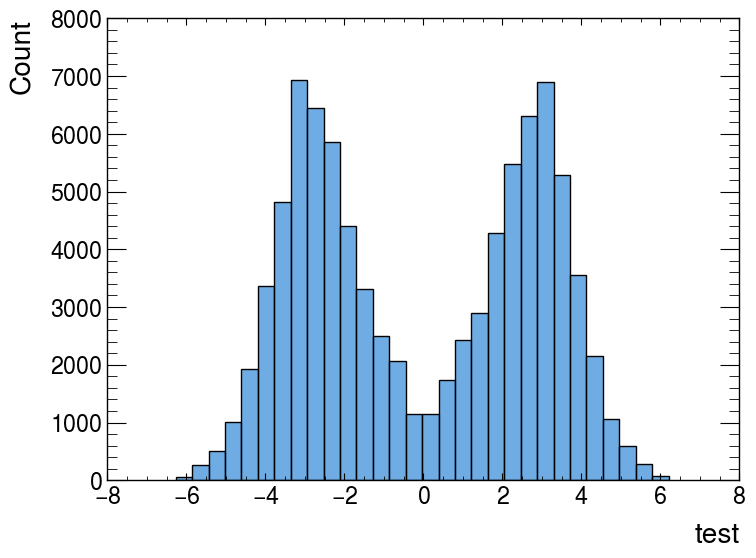

In [109]:
sns.histplot(data_det['test'],bins=30)

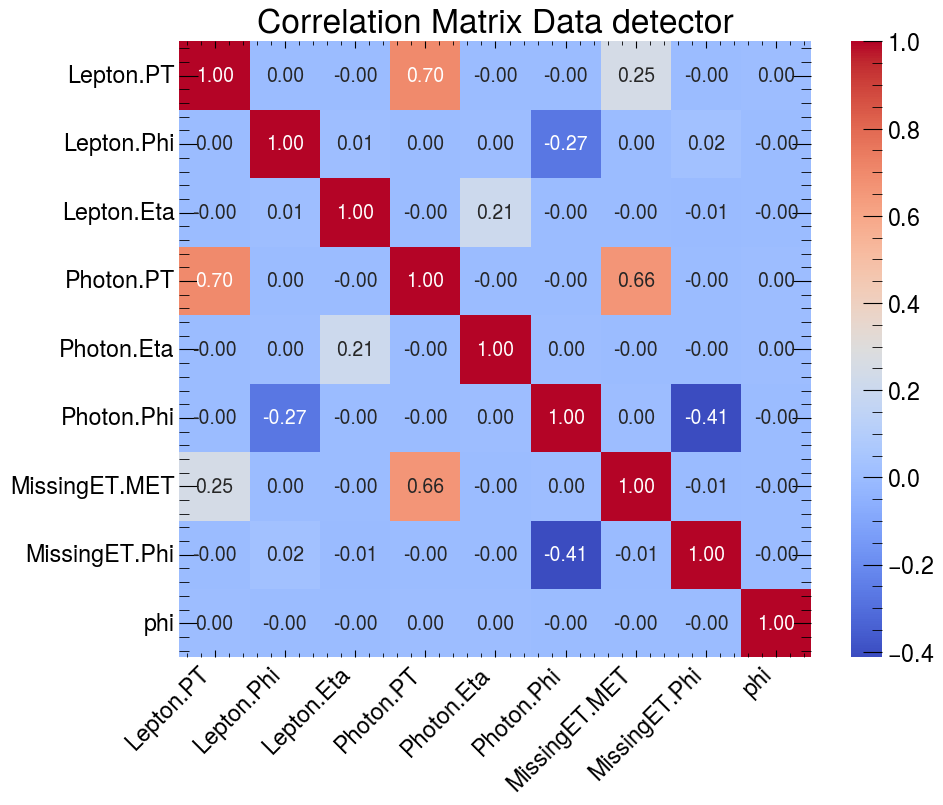

In [112]:
extra=['dPhi','phi']
corr_matrix=data_det[unfold_vars_full+['phi']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix Data detector")
plt.xticks(rotation=45, ha='right')
plt.show()

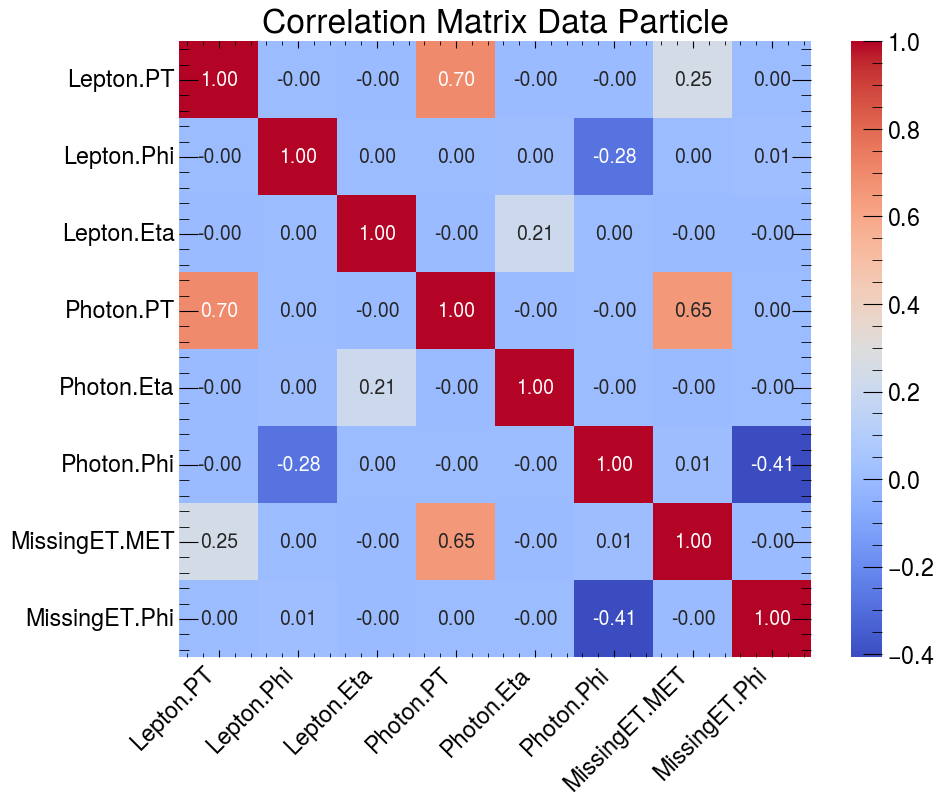

In [224]:
corr_matrix=data_part[unfold_vars_full].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix Data Particle")
plt.xticks(rotation=45, ha='right')
plt.show()

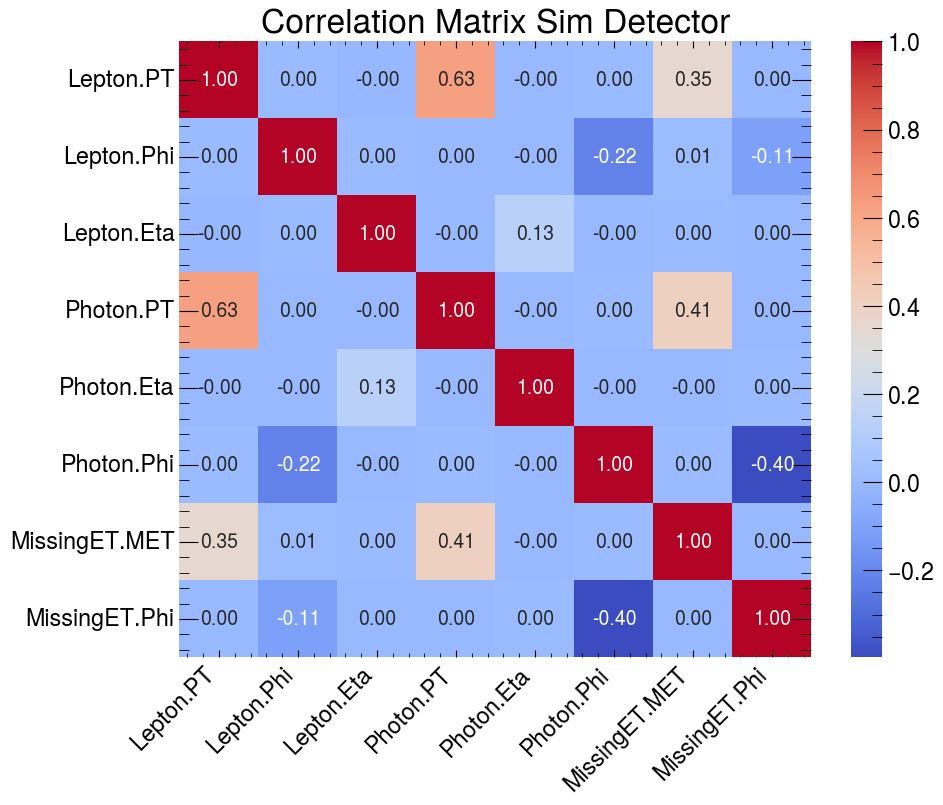

In [225]:
corr_matrix=sim_det[unfold_vars_full].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix Sim Detector")
plt.xticks(rotation=45, ha='right')
plt.show()

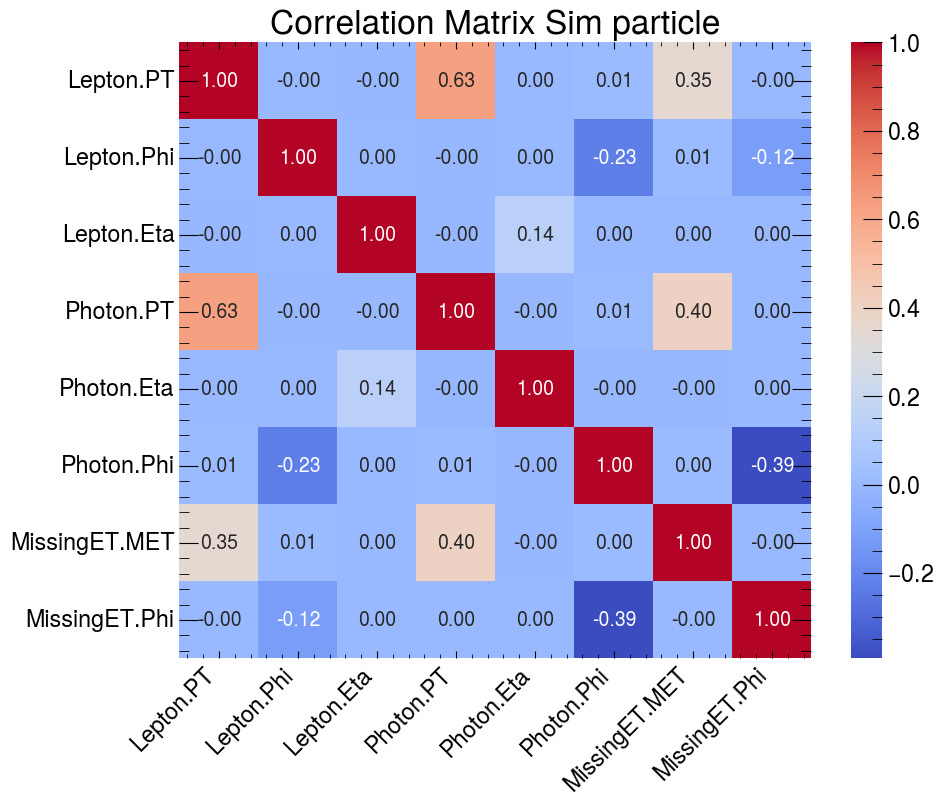

In [226]:
corr_matrix=sim_part[unfold_vars_full].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix Sim particle")
plt.xticks(rotation=45, ha='right')
plt.show()